# Multiclass Classification-Based Recommendation System

Dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset/data)

Introduction
1. Background and Motivation

Agriculture is a critical sector that depends on various environmental and soil parameters to determine the best crops for cultivation.
Choosing the right crop can optimize yield, reduce costs, and enhance farm productivity.
2. Problem Statement

Farmers often lack the tools to make data-driven decisions about which crops to grow based on their specific soil and environmental conditions.
There is a need for a predictive model that can recommend the most suitable crops based on parameters such as Nitrogen (N), Phosphorous (P), Potassium (K) content, temperature, humidity, pH, and rainfall.
3. Objectives

Develop a predictive model that analyzes soil and environmental data to recommend the optimal crop for a given farm.
Utilize historical data to train the model and ensure it provides accurate and actionable recommendations.
4. Methodology

Collect and preprocess a dataset containing soil and environmental parameters along with crop labels.
Apply classification algorithms to predict the crop type based on the given parameters.
Evaluate model performance using metrics such as accuracy, precision, recall, and F1-score.
5. Expected Outcomes

A robust model capable of recommending suitable crops based on various input parameters.
Insights into which factors most significantly impact crop suitability.
6. Significance

This model will aid farmers in making informed decisions, improving agricultural practices, and enhancing overall productivity.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns


import time
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import hamming_loss, jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve

# Load the dataset
data = pd.read_csv('../data/Crop_recommendation.csv')

# Encode the categorical label
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Define features and target
X = data[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor pipeline (here we're just using a standard scaler as an example)
num_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ])

# Specify models for comparison
classifiers = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('CatBoost', CatBoostClassifier(verbose=0, random_state=42))
]

# Assemble everything in a pipeline
pipelines = [(name, Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])) for name, model in classifiers]

# Scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
results = []
for name, pipeline in pipelines:
    scores = {}
    start_time = time.time()
    for metric_name, scorer in scoring.items():
        cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scorer, n_jobs=-1)
        scores[f"{metric_name}"] = np.mean(cv_results['test_score'])
        scores[f"{metric_name}_sd"] = np.std(cv_results['test_score'])
    end_time = time.time()
    training_time = end_time - start_time
    scores['training_time'] = training_time
    results.append((name, scores))

# DataFrame for comparison
results_df = pd.DataFrame(results, columns=['Model', 'Scores'])
scores_df = results_df['Scores'].apply(pd.Series)
results_df = pd.concat([results_df[['Model']], scores_df], axis=1).round(3)
results_df = results_df.set_index('Model')

In [22]:
results_df.sort_values(by=['f1', 'precision', 'recall'], ascending=False)

accuracy  accuracy_sd  precision  precision_sd  \
Model                                                                    
Random Forest              0.994        0.003      0.994         0.003   
CatBoost                   0.993        0.003      0.994         0.002   
Gradient Boosting          0.990        0.001      0.991         0.001   
Support Vector Machine     0.985        0.006      0.987         0.005   
Decision Tree              0.985        0.005      0.986         0.004   
XGBoost                    0.985        0.002      0.986         0.002   
K-Nearest Neighbors        0.975        0.006      0.978         0.005   
Logistic Regression        0.944        0.007      0.950         0.007   
AdaBoost                   0.165        0.022      0.082         0.012   

                        recall  recall_sd     f1  f1_sd  training_time  
Model                                                                   
Random Forest            0.994      0.003  0.994  0.003          0.936  
CatBoost                 0.993      0.003  0.993  0.003         74.795  
Gradient Boosting        0.990      0.001  0.990  0.001         22.846  
Support Vector Machine   0.985      0.006  0.985  0.006          0.601  
Decision Tree            0.985      0.005  0.985  0.005          0.100  
XGBoost                  0.985      0.002  0.985  0.002          0.778  
K-Nearest Neighbors      0.975      0.005  0.975  0.005          0.124  
Logistic Regression      0.943      0.007  0.942  0.008          3.090  
AdaBoost                 0.155      0.022  0.094  0.016          0.520

In [23]:
# GA KEPAKE
# train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14
      papaya       1.00    

In [26]:
# build pipelines
rf_clf = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
display(rf_clf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N', 'P', 'K', 'temperature',
                                                   'humidity', 'ph',
                                                   'rainfall'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [28]:
# build pipelines
rf_clf = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_weighted': make_scorer(f1_score, average='weighted')
}

# Perform cross-validation
cv_results = cross_validate(rf_clf, X_train, y_train, cv=skf, scoring=scoring, return_train_score=True)

# Create a DataFrame to store the results
rf_score_df = pd.DataFrame({
    'Fold': range(1, skf.get_n_splits() + 1),
    'Train Accuracy': cv_results['train_accuracy'],
    'Test Accuracy': cv_results['test_accuracy'],
    'Train F1 Score': cv_results['train_f1_weighted'],
    'Test F1 Score': cv_results['test_f1_weighted'],
    'Train Recall': cv_results['train_recall'],
    'Test Recall': cv_results['test_recall'],
    'Train Precision': cv_results['train_precision_weighted'],
    'Test Precision': cv_results['test_precision_weighted'],
    'TT': cv_results['fit_time']
})

# Calculate and add mean and standard deviation to the DataFrame
mean_accuracy = rf_score_df['Test Accuracy'].mean()
std_accuracy = rf_score_df['Test Accuracy'].std()
mean_f1 = rf_score_df['Test F1 Score'].mean()
std_f1 = rf_score_df['Test F1 Score'].std()
mean_recall = rf_score_df['Test Recall'].mean()
std_recall = rf_score_df['Test Recall'].std()
mean_precision = rf_score_df['Test Precision'].mean()
std_precision = rf_score_df['Test Precision'].std()
mean_tt = rf_score_df['TT'].mean()
std_tt = rf_score_df['TT'].std()

# Display the results
display(rf_score_df.round(4))
print("\nMean test accuracy: {:.4f} (Std: {:.4f})".format(mean_accuracy, std_accuracy))
print("Mean test F1 score: {:.4f} (Std: {:.4f})".format(mean_f1, std_f1))
print("Mean test recall: {:.4f} (Std: {:.4f})".format(mean_recall, std_recall))
print("Mean test recall: {:.4f} (Std: {:.4f})".format(mean_precision, std_precision))
print("Mean training time: {:.4f} (Std: {:.4f})".format(mean_tt, std_tt))

Fold  Train Accuracy  Test Accuracy  Train F1 Score  Test F1 Score  \
0     1             1.0         0.9972             1.0         0.9972   
1     2             1.0         0.9886             1.0         0.9886   
2     3             1.0         0.9915             1.0         0.9915   
3     4             1.0         0.9972             1.0         0.9972   
4     5             1.0         0.9943             1.0         0.9943   

   Train Recall  Test Recall  Train Precision  Test Precision      TT  
0           1.0       0.9972              1.0          0.9973  0.1947  
1           1.0       0.9886              1.0          0.9901  0.1462  
2           1.0       0.9915              1.0          0.9916  0.1469  
3           1.0       0.9972              1.0          0.9973  0.1463  
4           1.0       0.9943              1.0          0.9947  0.1488


Mean test accuracy: 0.9938 (Std: 0.0037)
Mean test F1 score: 0.9937 (Std: 0.0037)
Mean test recall: 0.9938 (Std: 0.0037)
Mean test recall: 0.9942 (Std: 0.0033)
Mean training time: 0.1566 (Std: 0.0213)


In [29]:
print(rf_clf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N', 'P', 'K', 'temperature',
                                                   'humidity', 'ph',
                                                   'rainfall'])])),
                ('classifier', RandomForestClassifier(random_state=42))])


In [30]:
# evaluate the model
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14
      papaya       1.00    

In [33]:
# FOR DEBUGGING PIPELINE
print(rf_clf)

# Using StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_clf, X_train, y_train, cv=skf, scoring='accuracy')

print(f"Cross-validation scores: {scores}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N', 'P', 'K', 'temperature',
                                                   'humidity', 'ph',
                                                   'rainfall'])])),
                ('classifier', RandomForestClassifier(random_state=42))])
Cross-validation scores: [0.99715909 0.98863636 0.99147727 0.99715909 0.99431818]


In [37]:
# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV with the pipeline
f1_scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.99544814438372


In [40]:
# Evaluate the model with the best found parameters on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14
      papaya       1.00    

In [38]:
# Calculate Hamming Loss
print("Hamming Loss:", round(hamming_loss(y_test, y_pred), 4))

# Jaccard Similarity Score
# print("Jaccard Score:", jaccard_score(y_test, y_pred, average='samples'))

# Classification Report
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Hamming Loss: 0.0068


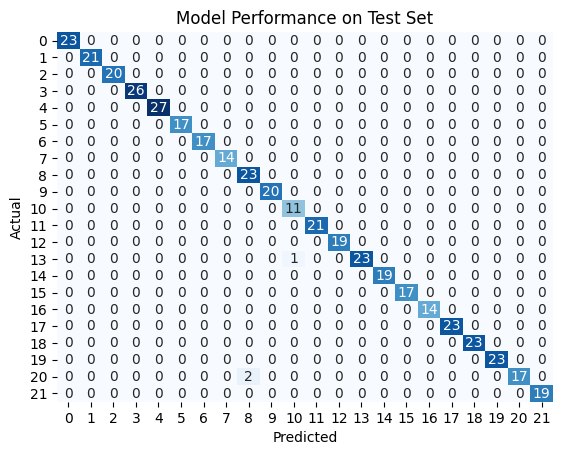

In [41]:
y_pred_xgb = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Model Performance on Test Set')
plt.show()

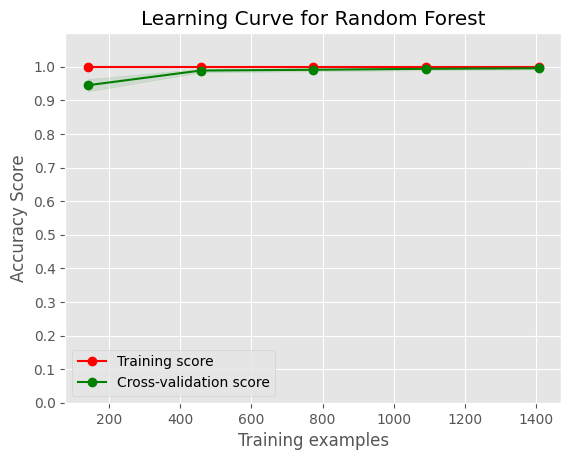

In [42]:
plt.style.use('ggplot')

# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plt.figure(dpi=200)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve for Random Forest')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

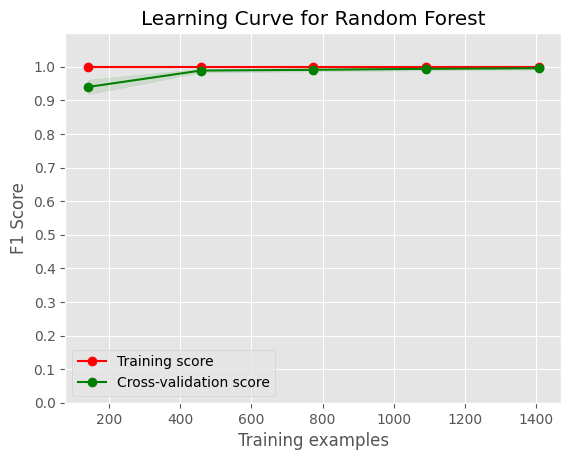

In [45]:
# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring=f1_scorer, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plt.figure(dpi=200)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('F1 Score')
plt.title('Learning Curve for Random Forest')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

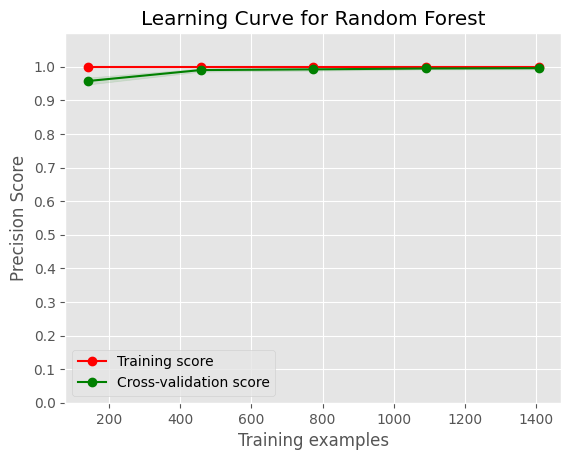

In [44]:
# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, 
                                                        scoring=make_scorer(precision_score, average='weighted'), 
                                                        n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plt.figure(dpi=200)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('Precision Score')
plt.title('Learning Curve for Random Forest')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

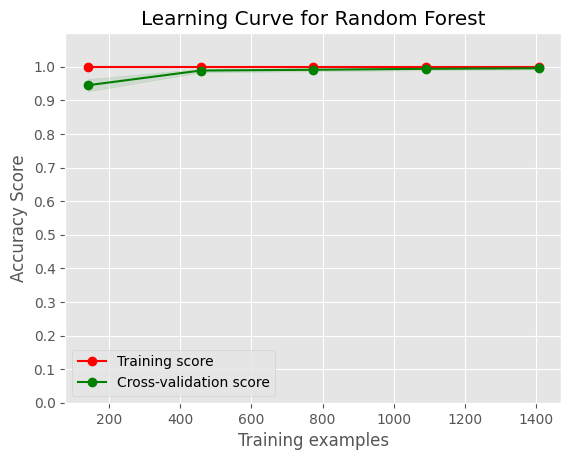

In [46]:
# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, 
                                                        scoring=make_scorer(recall_score, average='weighted'), 
                                                        n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plt.figure(dpi=200)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve for Random Forest')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

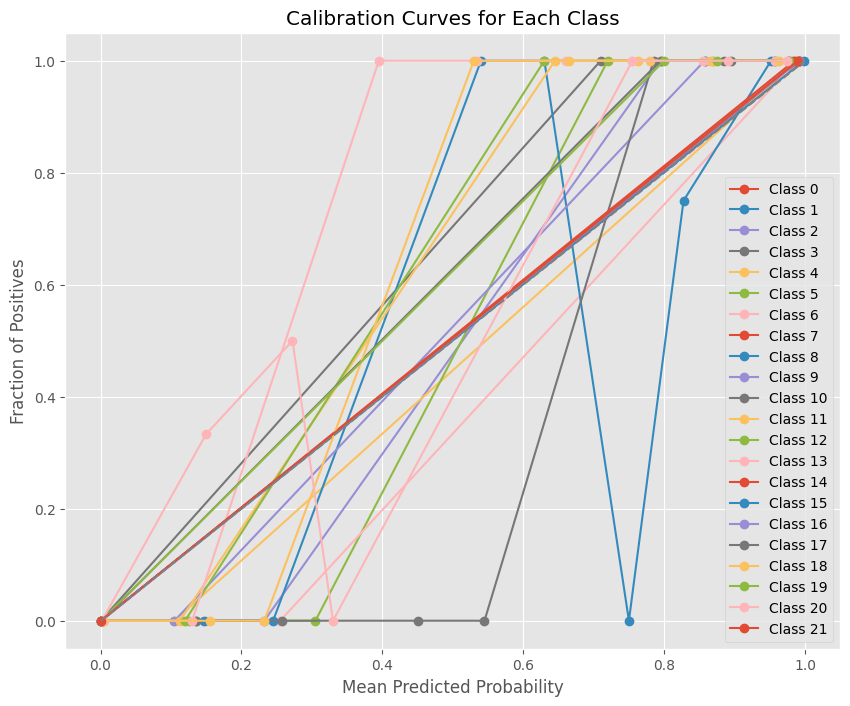

In [47]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

# Assuming 'best_model' is your trained model and 'X_test' is your test data
y_pred_proba = best_model.predict_proba(X_test)

# Binarize the y_test for multiclass
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)

# Plot calibration curve for each class
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(best_model.classes_):
    prob_true, prob_pred = calibration_curve(y_test_binarized[:, i], y_pred_proba[:, i], n_bins=10)
    
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_label}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves for Each Class')
plt.legend(loc='best')
plt.show()

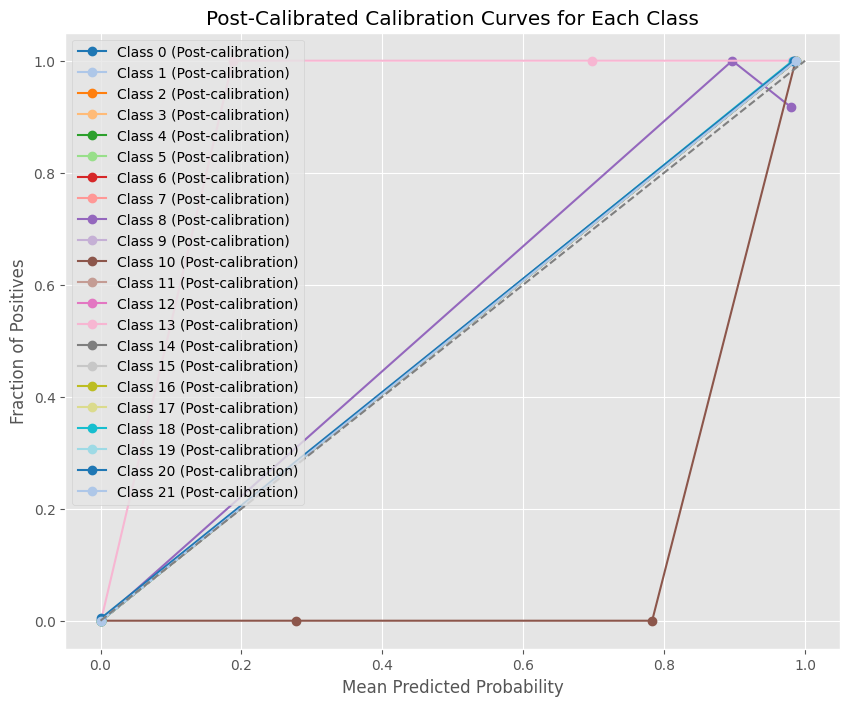

In [49]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.preprocessing import label_binarize

# Calibrate the model using CalibratedClassifierCV
calibrated_model = CalibratedClassifierCV(estimator=best_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train, y_train)

# Predict post-calibrated probabilities on the test set
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)

# Binarize the y_test for multiclass calibration curve
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)

# Define a colormap
cmap = plt.get_cmap('tab20')

# Plot post-calibration calibration curve for each class
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(best_model.classes_):
    color = cmap(i % 20)
    prob_true, prob_pred = calibration_curve(y_test_binarized[:, i], y_pred_proba_calibrated[:, i], n_bins=10)
    
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_label} (Post-calibration)', color=color)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Post-Calibrated Calibration Curves for Each Class')
plt.legend(loc='upper left')
plt.show()


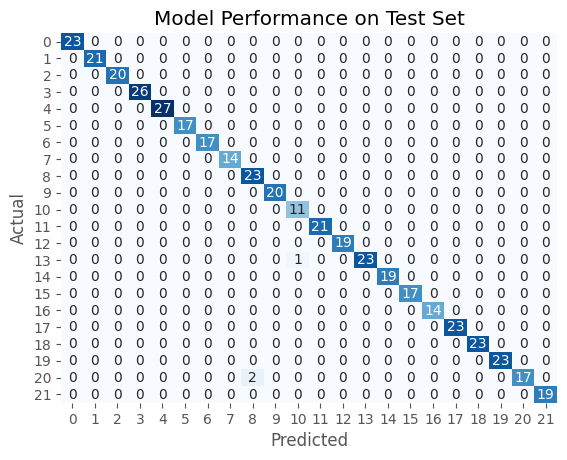

In [50]:
y_pred_xgb = calibrated_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Model Performance on Test Set')
plt.show()

## **2 Data Preparation & Exploration**

In [572]:
from scipy.stats import skew, kurtosis, kstest, shapiro 
import ptitprince as pt
from matplotlib import colormaps
list(colormaps)[120:130]

['afmhot_r',
 'autumn_r',
 'binary_r',
 'bone_r',
 'brg_r',
 'bwr_r',
 'cool_r',
 'coolwarm_r',
 'copper_r',
 'cubehelix_r']

### **2.1 Data Preparation**

In [573]:
data = pd.read_csv('../data/Crop_recommendation.csv')

In [574]:
# create function to inspect df
def inspect_dataframe(df):
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

print(f'The dataframe contains {data.shape[0]} rows and {data.shape[1]} cols.')
print(f"- {len(data.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(data.select_dtypes(include='O').columns)} are object cols")
inspect_dataframe(data)

The dataframe contains 2200 rows and 8 cols.
- 7 are numeric cols
- 1 are object cols


ColumnName  Nrow DataType  NAPct  DuplicatePct  UniqueValue  \
0            N  2200    int64    0.0           0.0          137   
1            P  2200    int64    0.0           0.0          117   
2            K  2200    int64    0.0           0.0           73   
3  temperature  2200  float64    0.0           0.0         2200   
4     humidity  2200  float64    0.0           0.0         2200   
5           ph  2200  float64    0.0           0.0         2200   
6     rainfall  2200  float64    0.0           0.0         2200   
7        label  2200   object    0.0           0.0           22   

                                              Sample  
0  [90, 85, 60, 74, 78, 69, 94, 89, 68, 91, 93, 7...  
1  [42, 58, 55, 35, 37, 53, 54, 46, 56, 50, 48, 3...  
2  [43, 41, 44, 40, 42, 38, 36, 37, 39, 35, 45, 1...  
3  [20.87974371, 21.77046169, 23.00445915, 26.491...  
4  [82.00274423, 80.31964408, 82.3207629, 80.1583...  
5  [6.502985292000001, 7.038096361, 7.840207144, ...  
6  [202.9355362, 226.6555374, 263.9642476, 242.86...  
7  [rice, maize, chickpea, kidneybeans, pigeonpea...

## **3 Data Exploration**

### **3.1 Is there any imbalance class problem?**

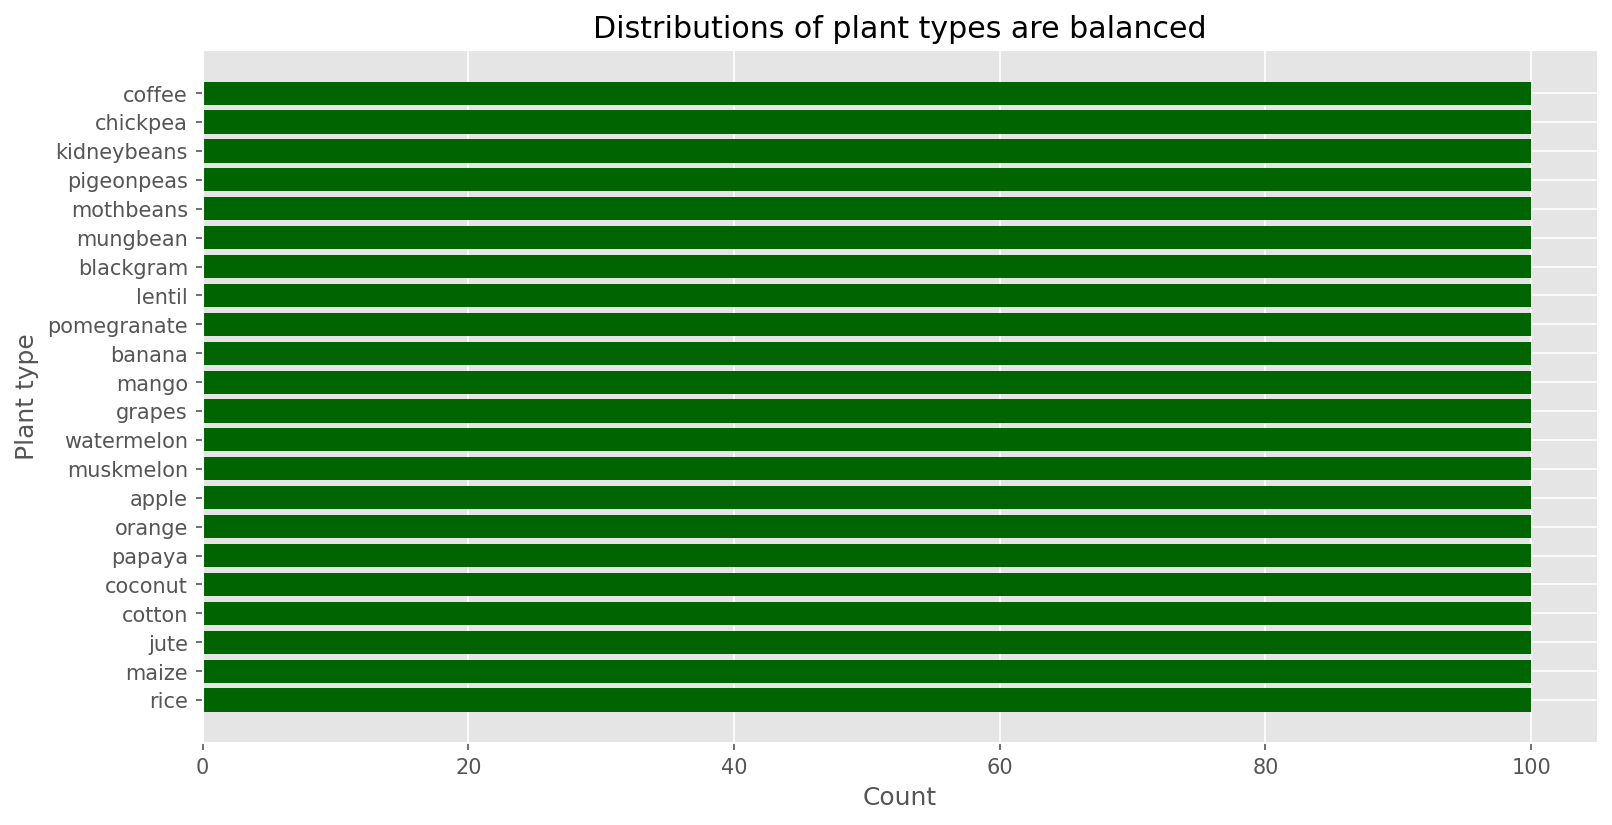

In [575]:
plat_df = data['label'].value_counts().reset_index(name='count')
plt.figure(figsize=(12, 6), dpi=150)
plt.barh(plat_df['index'], plat_df['count'], color ='darkgreen')
plt.xlabel('Count')
plt.ylabel('Plant type')
plt.title('Distributions of plant types are balanced')
plt.show()

### **3.2 Do all numerical features follow normal distribution?**

In [576]:
normality_test = []
# Iterate over numerical columns
for col in data.select_dtypes(include='number').columns:
    data_feature = data[col].dropna()  # Drop NaNs if any

    if len(data_feature) > 1:  # Check if there's more than one value
        # Calculate statistics
        feature_skewness = skew(data_feature)
        feature_kurtosis = kurtosis(data_feature)
        feature_shapiro_stat, feature_shapiro_p = shapiro(data_feature)
        
        normality_test.append({
            'feature': col,
            'skewness': feature_skewness,
            'kurtosis': feature_kurtosis,
            'w': feature_shapiro_stat,
            'pvalue': feature_shapiro_p,
            'distribution': 'not normal' if feature_shapiro_p < 0.05 else 'normal'
        })

# convert results to DataFrame
pd.DataFrame(normality_test).round(4)

feature  skewness  kurtosis       w  pvalue distribution
0            N    0.5094   -1.0586  0.9154     0.0   not normal
1            P    1.0101    0.8556  0.9112     0.0   not normal
2            K    2.3735    4.4365  0.6055     0.0   not normal
3  temperature    0.1848    1.2270  0.9821     0.0   not normal
4     humidity   -1.0910    0.2987  0.8664     0.0   not normal
5           ph    0.2837    1.6491  0.9791     0.0   not normal
6     rainfall    0.9651    0.6030  0.9303     0.0   not normal

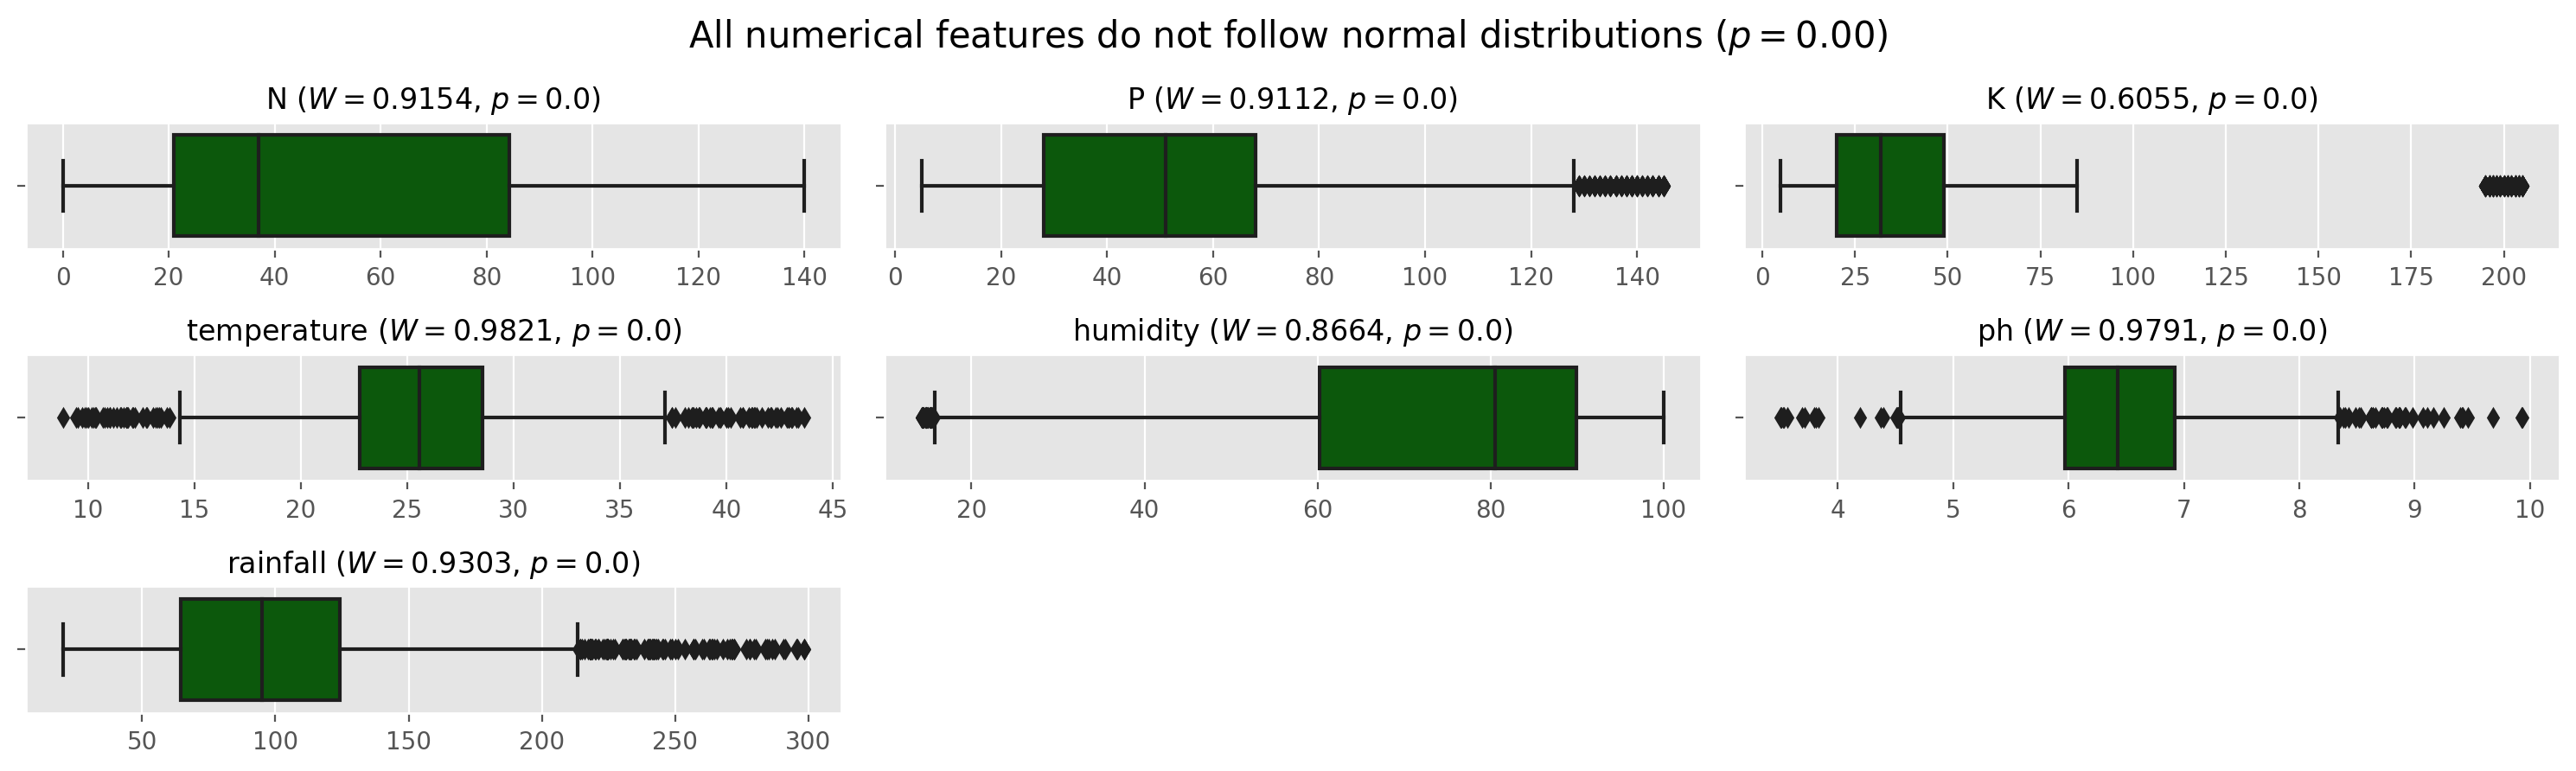

In [577]:
# compute SW test
df_numeric = data.select_dtypes(include='number')
shapiro_results = df_numeric.apply(lambda col: shapiro(col))
stats_df = pd.DataFrame({
    'column': df_numeric.columns,
    'sw_statistic': df_numeric.apply(lambda col: shapiro(col)[0]).values.round(4),
    'sw_pvalues': df_numeric.apply(lambda col: shapiro(col)[1]).values.round(4)
})

# display boxplots
plt.figure(figsize=(15, 7), dpi=200)
for i, col in enumerate(df_numeric.columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=data[col], color='darkgreen')
    # locate H stat and p-val
    row = stats_df[stats_df['column'] == col]
    statistic = row['sw_statistic'].values[0]
    p_value = row['sw_pvalues'].values[0]
    plt.title(f'{col} ($W = {statistic}$, $p = {p_value}$)', size=12)
    plt.xlabel(None)
plt.suptitle('All numerical features do not follow normal distributions ($p = 0.00$)', size=15)
plt.tight_layout()
plt.show()

Some columns contain outliers but it remains unclear whether the outliers represent genuine variability within the classes, not errors or anomalies. Evaluating these outliers further is required to determine if they are anomalies or real variability.

### **3.3 Which plants require extremely low and high temperatures?**

In [578]:
q1 = data['temperature'].quantile(0.25)
q3 = data['temperature'].quantile(0.75)
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr
lower_threshold = q1 - 1.5 * iqr
data[(data['temperature'] < lower_threshold) | (data['temperature'] > upper_threshold)]['label'].value_counts()

papaya    35
grapes    34
orange    17
Name: label, dtype: int64

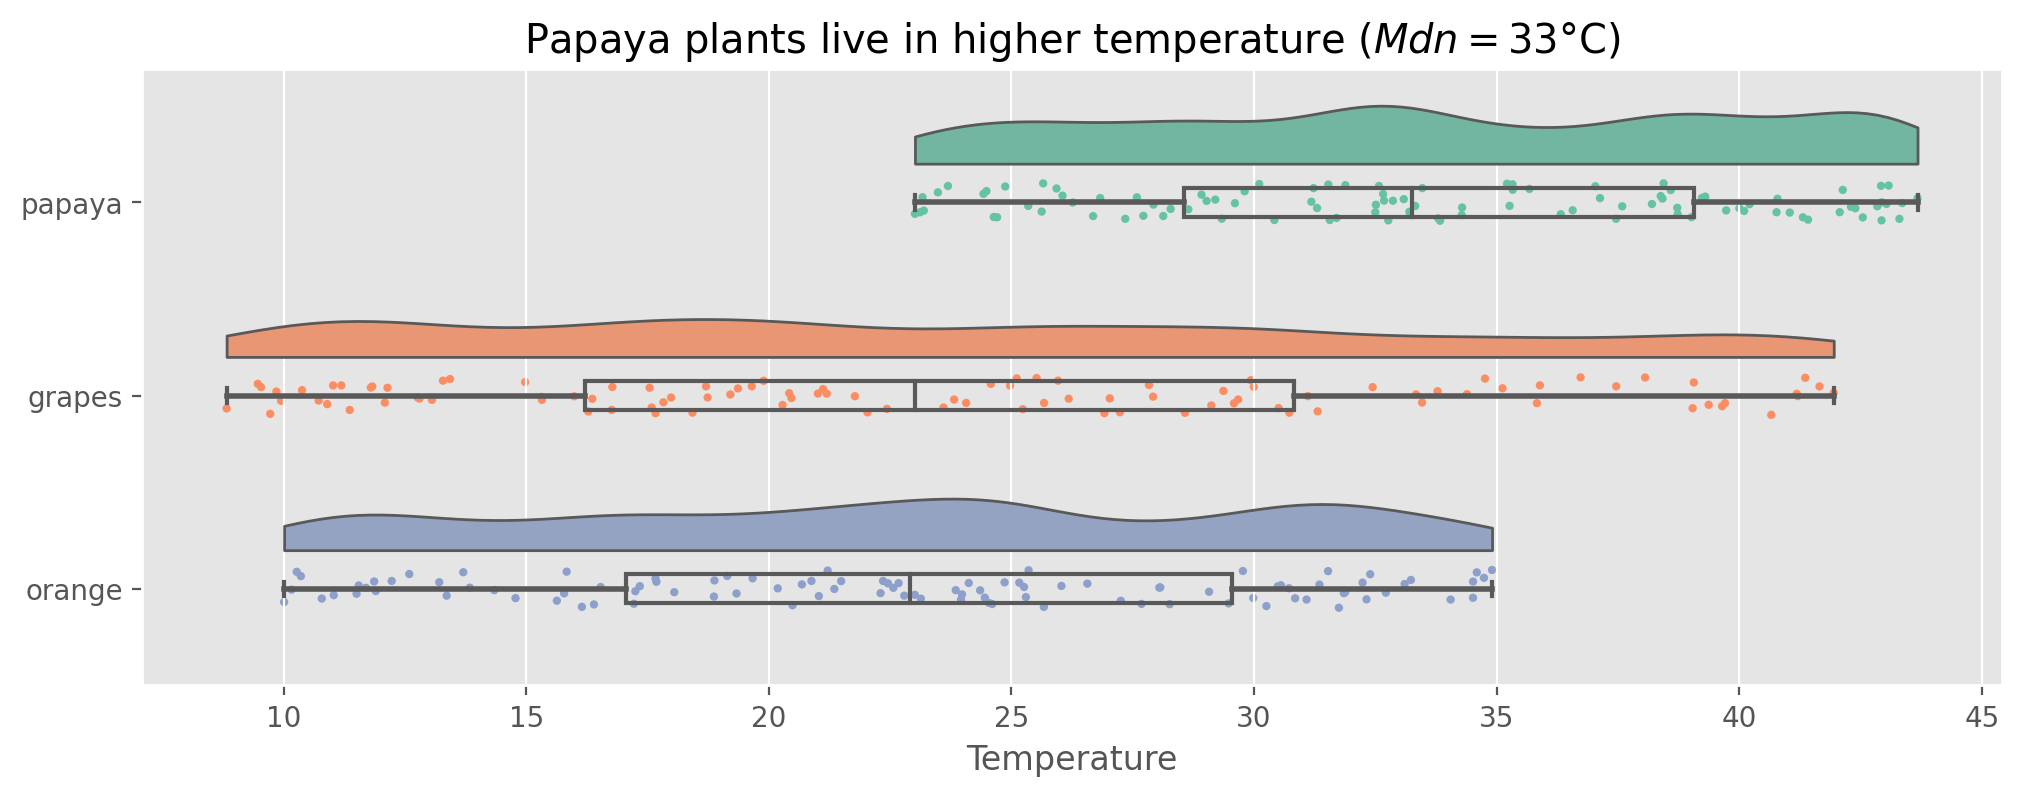

In [579]:
# Filter the relevant subset
subset_df = data[data['label'].isin(['papaya', 'grapes', 'orange'])]
medians = subset_df.groupby('label')['temperature'].median().sort_values(ascending=False)
sorted_labels = medians.index

plt.figure(figsize=(12, 4), dpi=200)
pt.RainCloud(x='label', y='temperature', data=subset_df, 
             palette='Set2', bw=.2, width_viol=.6, ax=None, orient='h', order=sorted_labels)

plt.title('Papaya plants live in higher temperature ($Mdn = 33\degree$C)')
plt.xlabel('Temperature')
plt.ylabel(None)
plt.show()

### **3.4 Which plant types require extremely low and high rainfall level?**

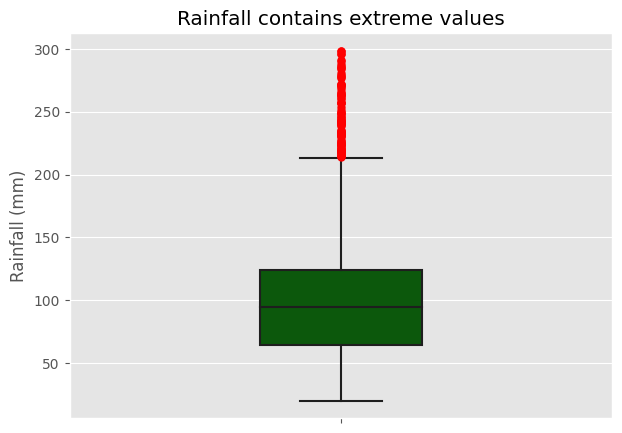

In [580]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=data['rainfall'], color='darkgreen', width=0.3, 
            flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, 
                            markersize=10))

plt.title('Rainfall contains extreme values')
plt.ylabel('Rainfall (mm)')
plt.show()

In [581]:
q1 = data['rainfall'].quantile(0.25)
q3 = data['rainfall'].quantile(0.75)
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr
data[(data['rainfall'] > upper_threshold)]['label'].value_counts()

rice       68
papaya     17
coconut    15
Name: label, dtype: int64

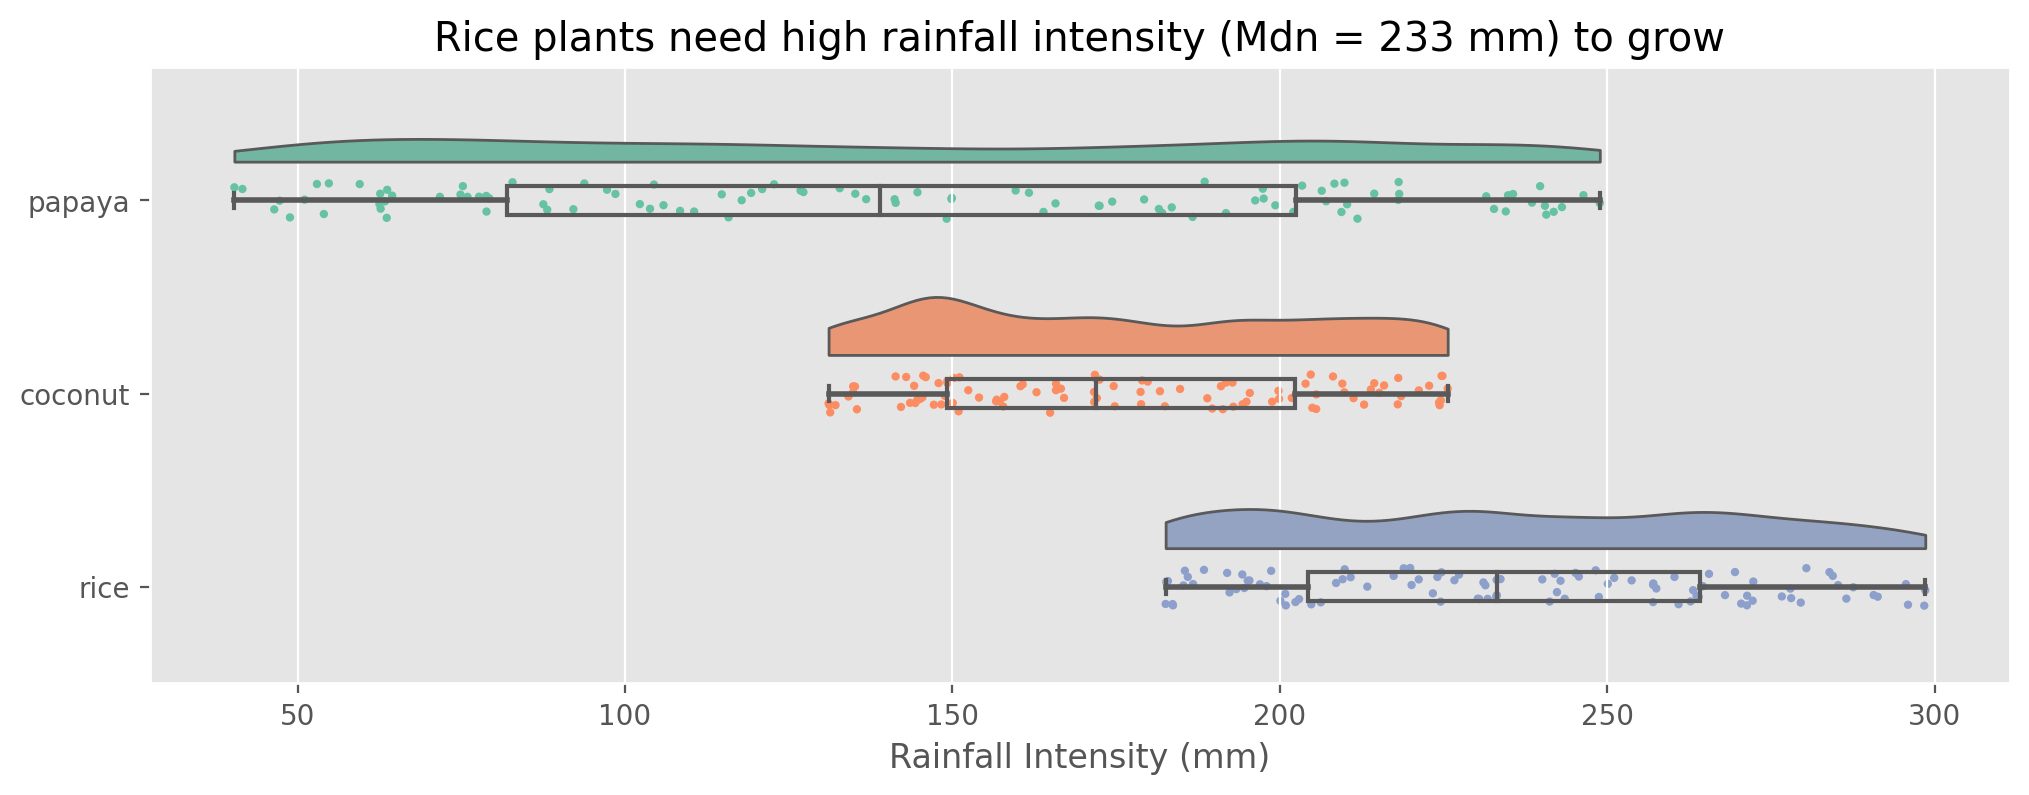

In [582]:
# Filter the relevant subset
subset_df = data[data['label'].isin(['rice', 'papaya', 'coconut'])]
medians = subset_df.groupby('label')['rainfall'].median().sort_values(ascending=True)
sorted_labels = medians.index

plt.figure(figsize=(12, 4), dpi=200)
pt.RainCloud(x='label', y='rainfall', data=subset_df, 
             palette='Set2', bw=.2, width_viol=.6, ax=None, orient='h', order=sorted_labels)

plt.title('Rice plants need high rainfall intensity (Mdn = 233 mm) to grow')
plt.xlabel('Rainfall Intensity (mm)')
plt.ylabel(None)
plt.show()

### **3.5 Which plant types require extremely low and high acidity (pH) level?**

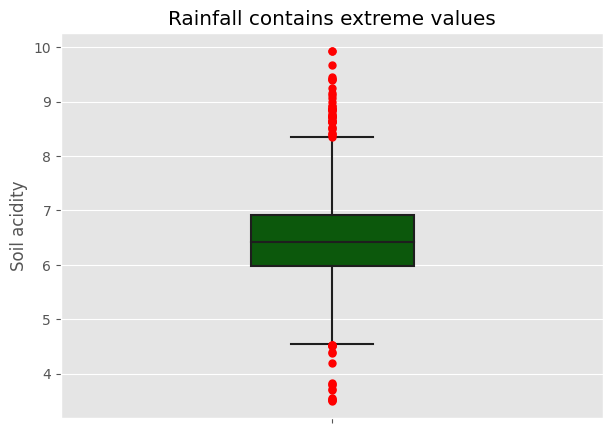

In [583]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=data['ph'], color='darkgreen', width=0.3, 
            flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, 
                            markersize=10))

plt.title('Rainfall contains extreme values')
plt.ylabel('Soil acidity')
plt.show()

In [584]:
q1 = data['ph'].quantile(0.25)
q3 = data['ph'].quantile(0.75)
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr
lower_threshold = q1 - 1.5 * iqr
data[(data['ph'] < lower_threshold) | (data['ph'] > upper_threshold)]['label'].value_counts()

mothbeans    42
chickpea     13
mango         2
Name: label, dtype: int64

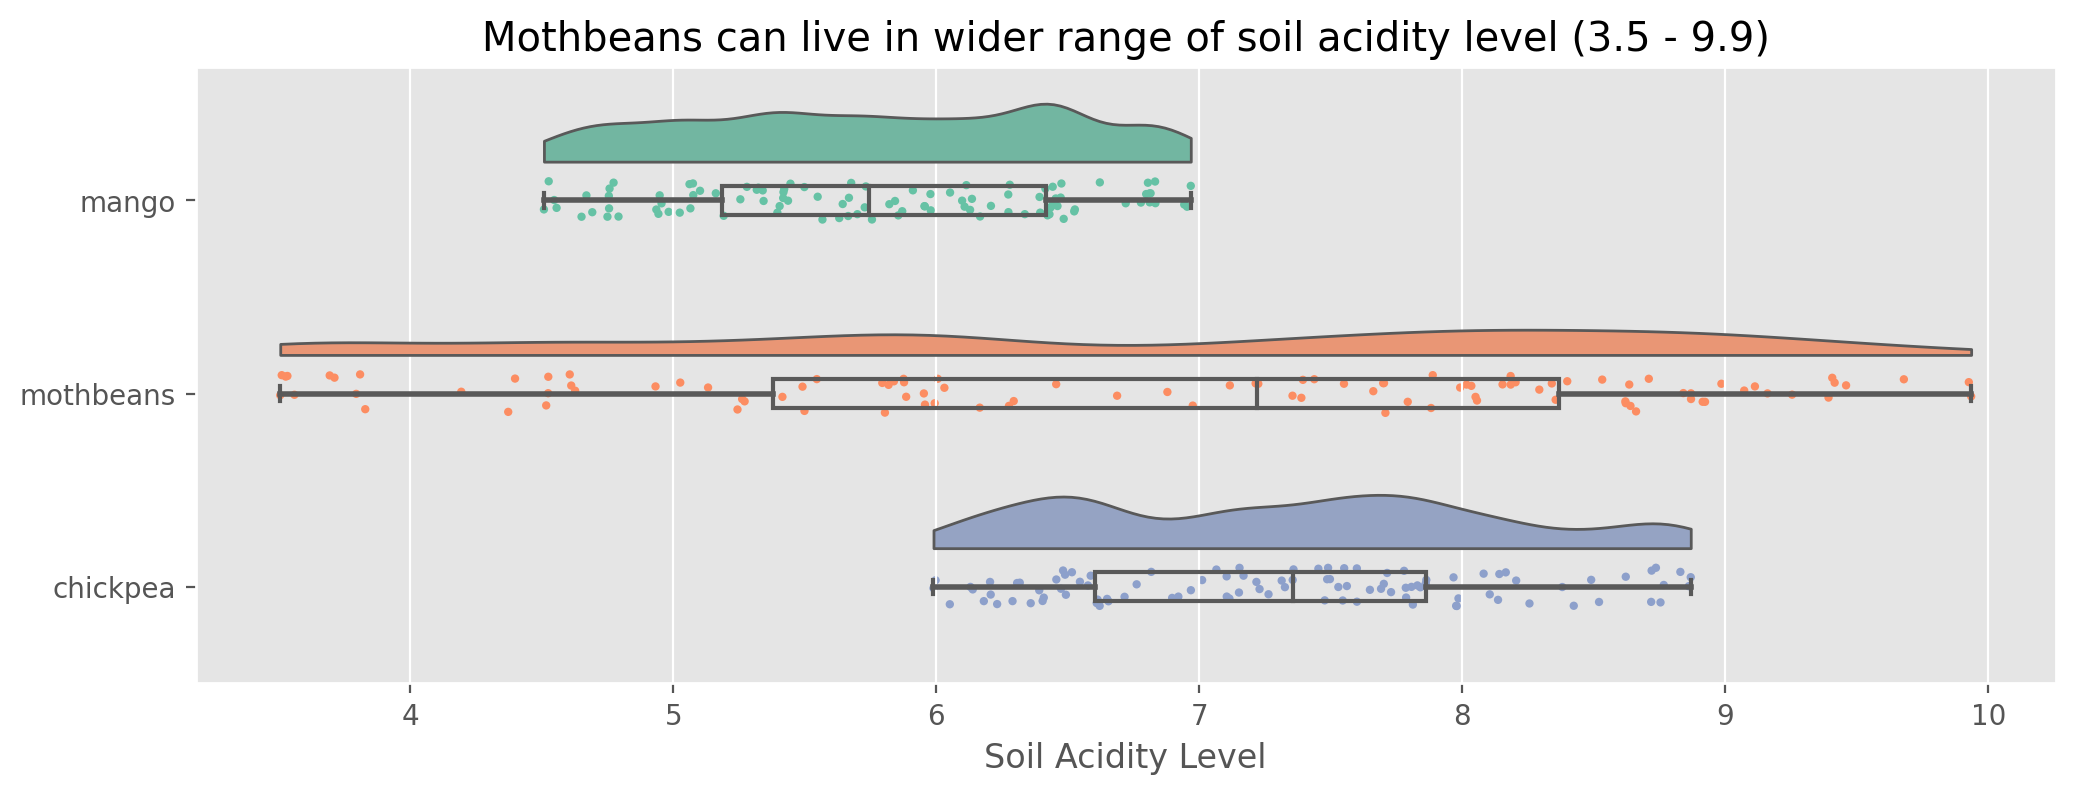

In [585]:
# Filter the relevant subset
subset_df = data[data['label'].isin(['mothbeans', 'chickpea', 'mango'])]
medians = subset_df.groupby('label')['ph'].median().sort_values(ascending=True)
sorted_labels = medians.index

plt.figure(figsize=(12, 4), dpi=200)
pt.RainCloud(x='label', y='ph', data=subset_df, 
             palette='Set2', bw=.2, width_viol=.6, ax=None, orient='h', order=sorted_labels)

plt.title('Mothbeans can live in wider range of soil acidity level (3.5 - 9.9)')
plt.xlabel('Soil Acidity Level')
plt.ylabel(None)
plt.show()

### **3.6 Which plants require extremely high and low humidity level?**

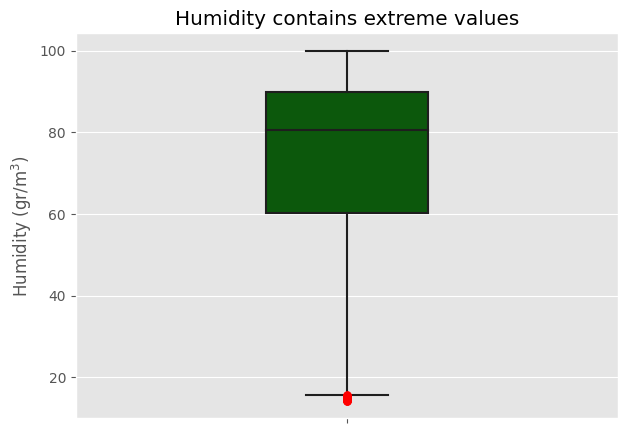

In [586]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=data['humidity'], color='darkgreen', width=0.3, 
            flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, 
                            markersize=10))

plt.title('Humidity contains extreme values')
plt.ylabel('Humidity (gr/m$^3$)')
plt.show()

In [587]:
q1 = data['humidity'].quantile(0.25)
q3 = data['humidity'].quantile(0.75)
iqr = q3 - q1
lower_threshold = q1 - 1.5 * iqr
data[(data['humidity'] < lower_threshold)]['label'].value_counts()

chickpea    30
Name: label, dtype: int64

In [588]:
data[data['label'] == 'chickpea']['humidity'].describe()

count    100.000000
mean      16.860439
std        1.711979
min       14.258040
25%       15.392700
50%       16.658634
75%       18.265986
max       19.969789
Name: humidity, dtype: float64

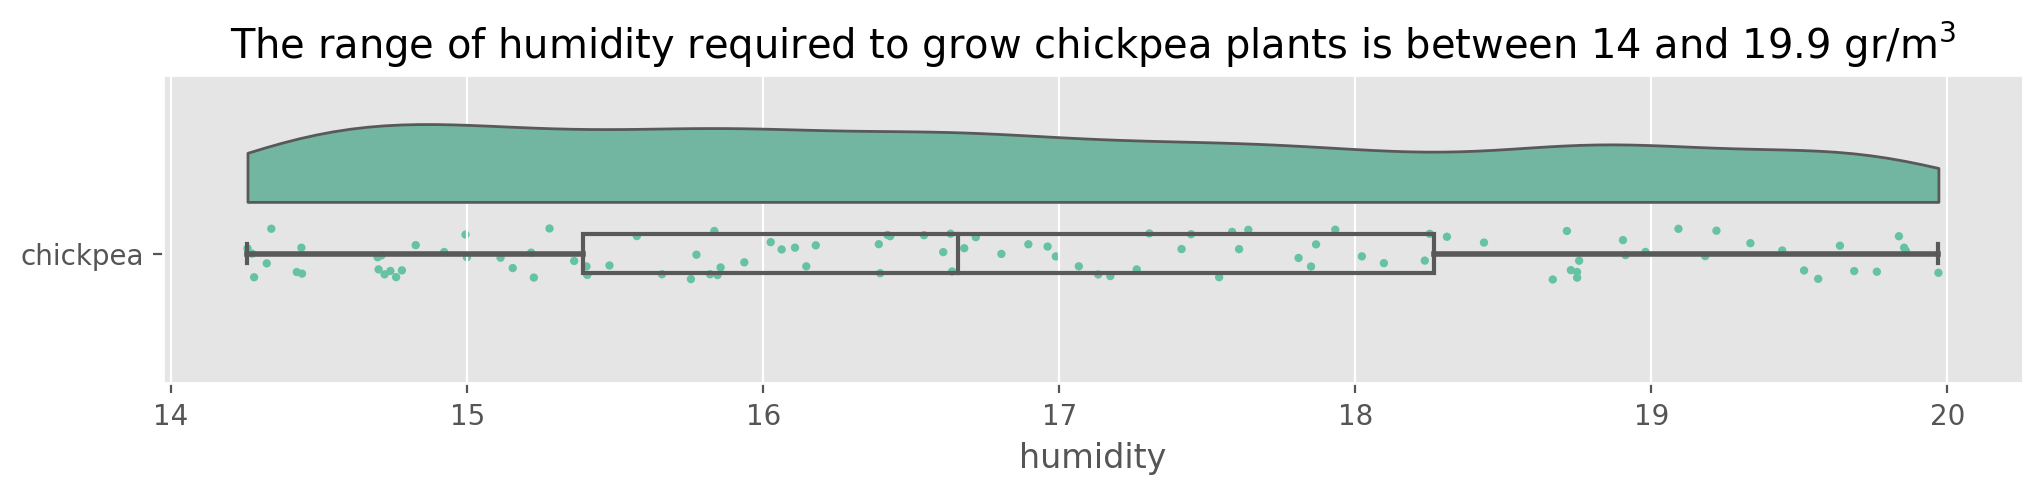

In [589]:
# set up the figure
plt.figure(figsize=(12, 2), dpi=200)
# use raincloud to display distribution
pt.RainCloud(x=data[data['label'] == 'chickpea']['label'], 
             y=data[data['label'] == 'chickpea']['humidity'],
             palette='Set2', bw=.2, width_viol=.6, ax=None, orient='h')
plt.title('The range of humidity required to grow chickpea plants is between 14 and 19.9 gr/m$^3$')
plt.ylabel('Humidity (gr/m$^3$)')
plt.ylabel(None)
plt.show()

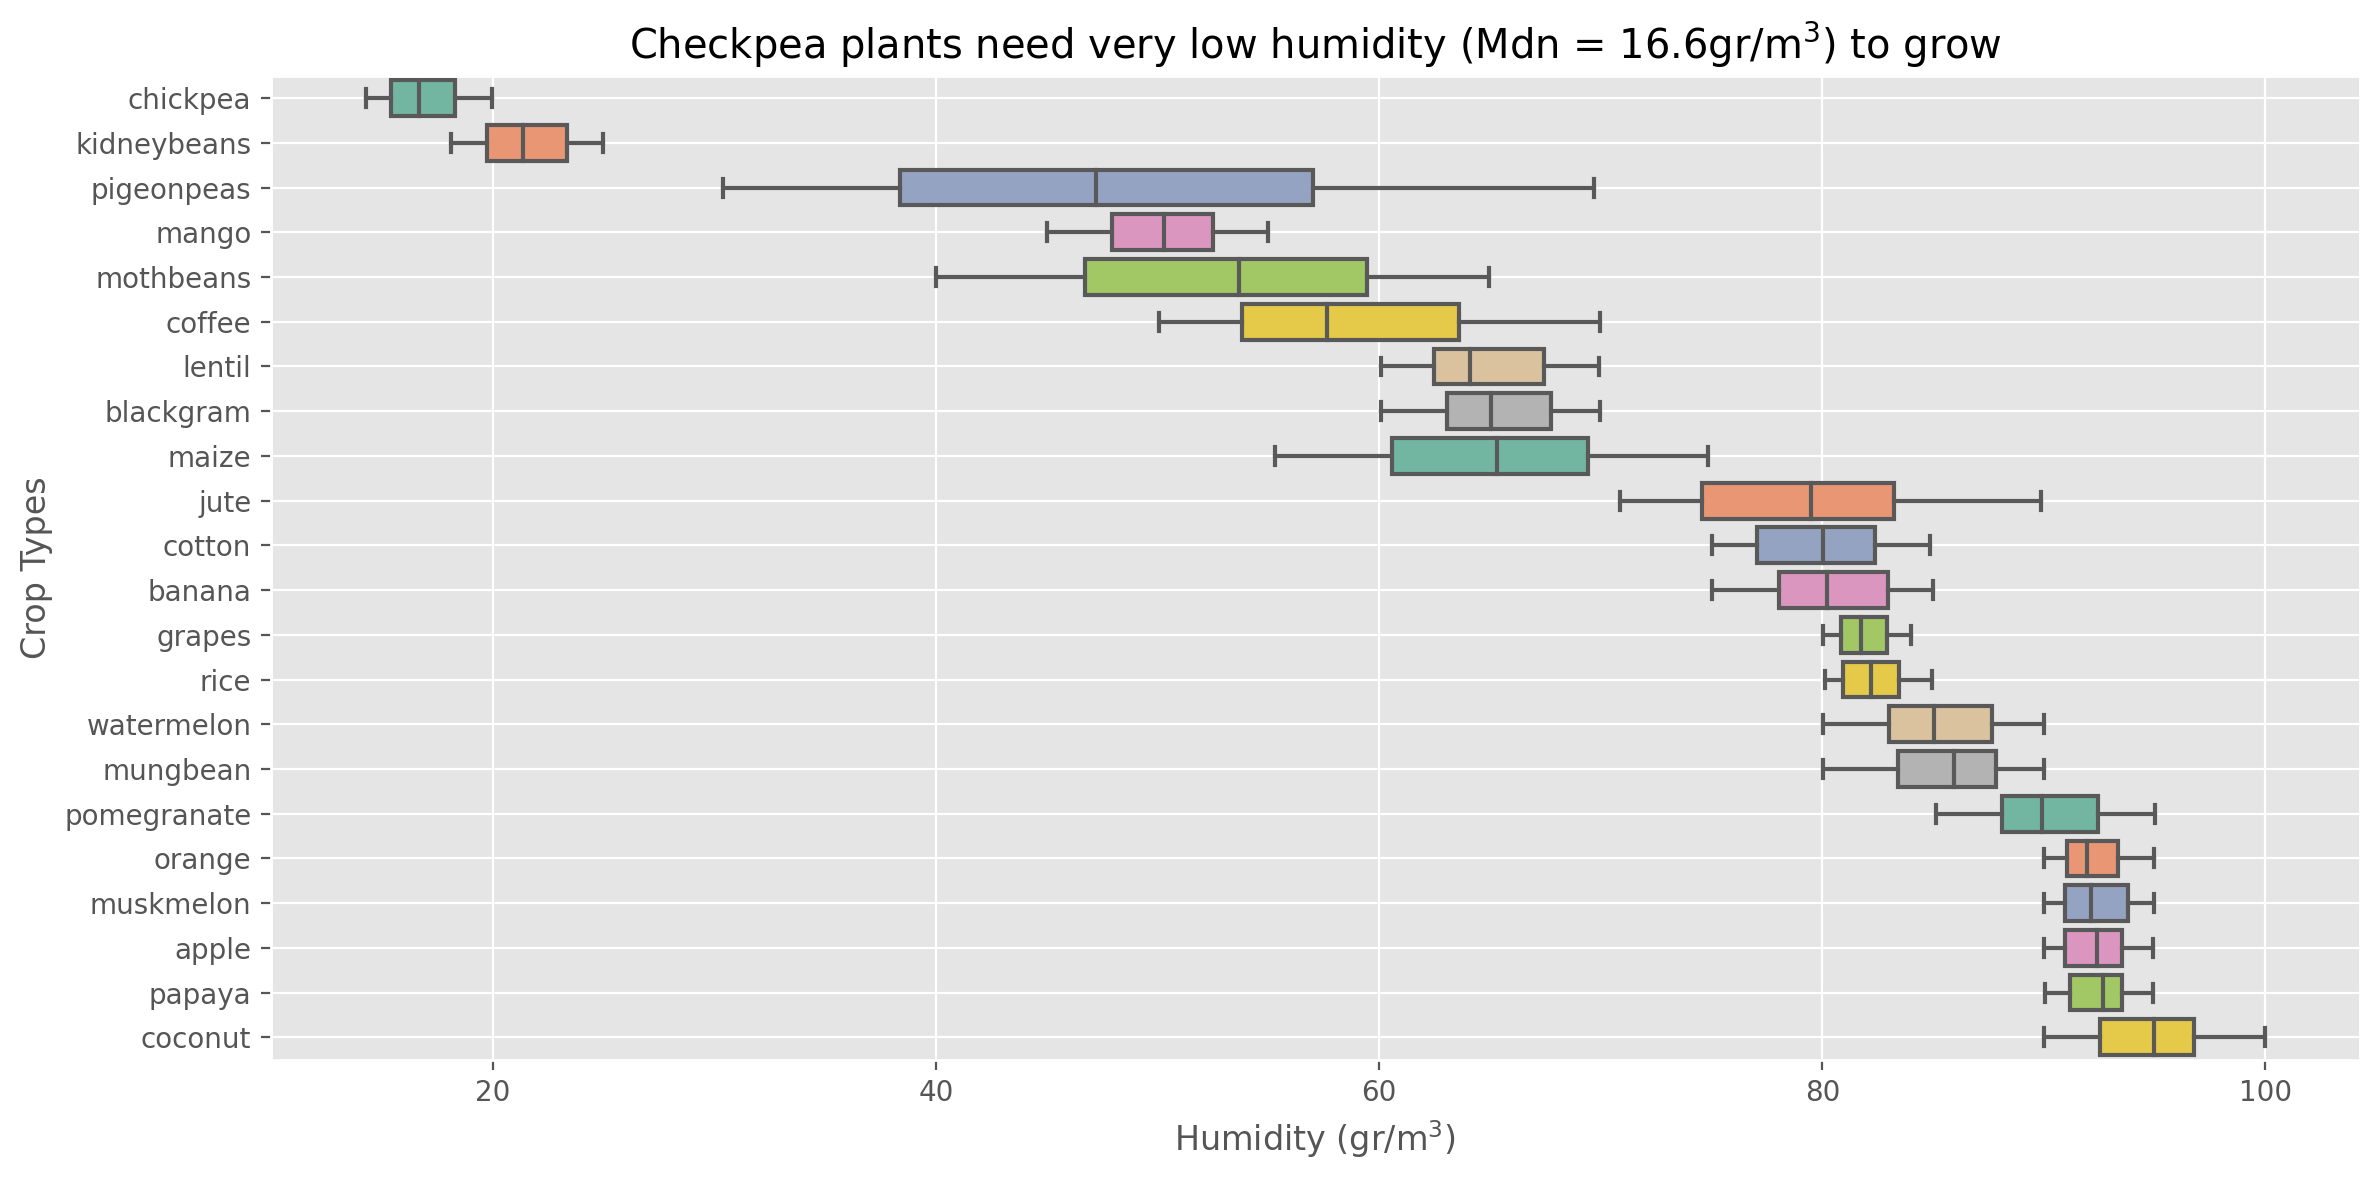

In [590]:
# compare chickpea to other plants
medians = data.groupby('label')['humidity'].median().sort_values()
sorted_labels = medians.index

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
sns.boxplot(y='label', x='humidity', data=data, order=sorted_labels, palette='Set2', ax=ax)
ax.grid(True)
ax.set_title('Checkpea plants need very low humidity (Mdn = 16.6gr/m$^3$) to grow')
ax.set_xlabel('Humidity (gr/m$^3$)')
ax.set_ylabel('Crop Types')
plt.tight_layout()
plt.show()

In [591]:
q1 = data['P'].quantile(0.25)
q3 = data['P'].quantile(0.75)
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr
data[data['P'] > upper_threshold]['label'].value_counts()

apple     70
grapes    68
Name: label, dtype: int64

In [592]:
data[data['K'] < 180]['label'].value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
muskmelon      100
watermelon     100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: label, dtype: int64

In [593]:
data[data['K'] > 180]['label'].value_counts()

grapes    100
apple     100
Name: label, dtype: int64

### **3.7 Are there any highly correlated or multicollinear features?**

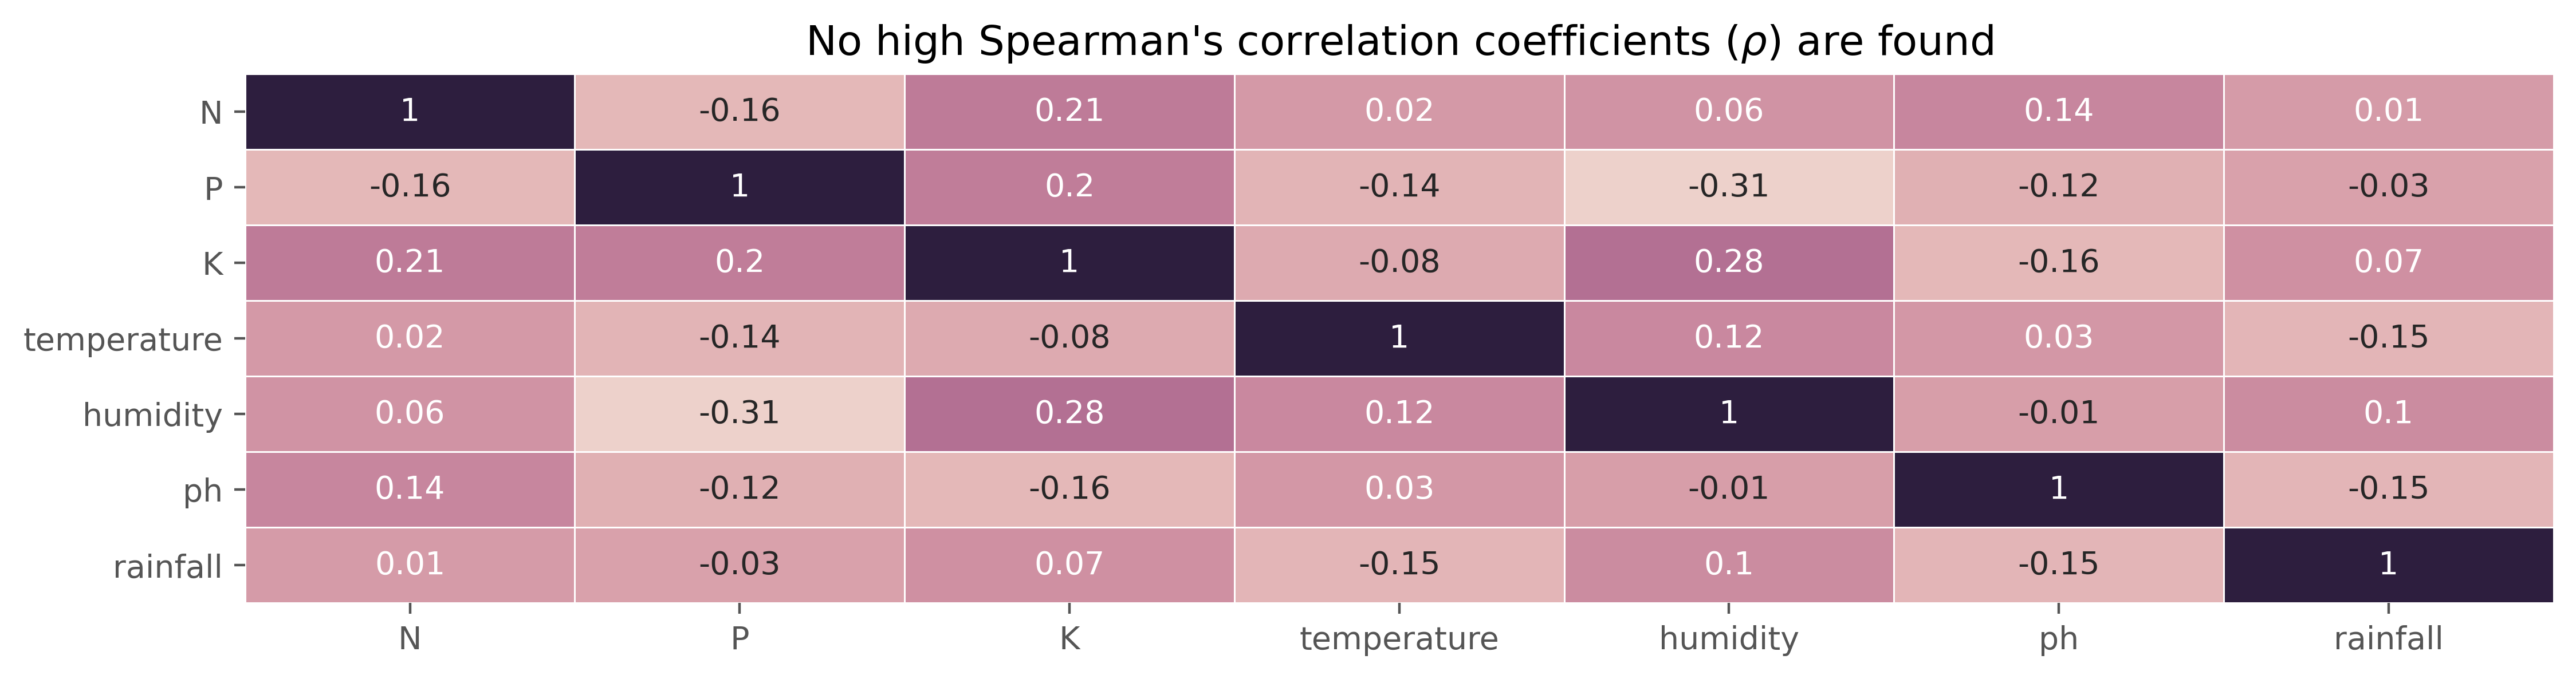

In [594]:
# build spearman correlation matrix
plt.figure(figsize=(13, 3), dpi=400)
correlation_matrix = data.corr(numeric_only=True, method='spearman').round(2)
sns.heatmap(correlation_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.5, cbar=False)
plt.title('No high Spearman\'s correlation coefficients ($\\rho$) are found', loc='center', fontsize=13)
plt.show()

In [595]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# filter num vars
X = data.select_dtypes(include='number')

# add intercept for VIF calculation
X = add_constant(X)

# compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.round(4)

Feature       VIF
0        const  127.0386
1            N    1.0970
2            P    2.6305
3            K    2.7971
4  temperature    1.1111
5     humidity    1.3690
6           ph    1.0558
7     rainfall    1.0374

### **3.8 Why does the pairwise correlation matrix indicate low coefficients?**

#### **3.8.1 Phosphor (P) vs Potassium (K)**

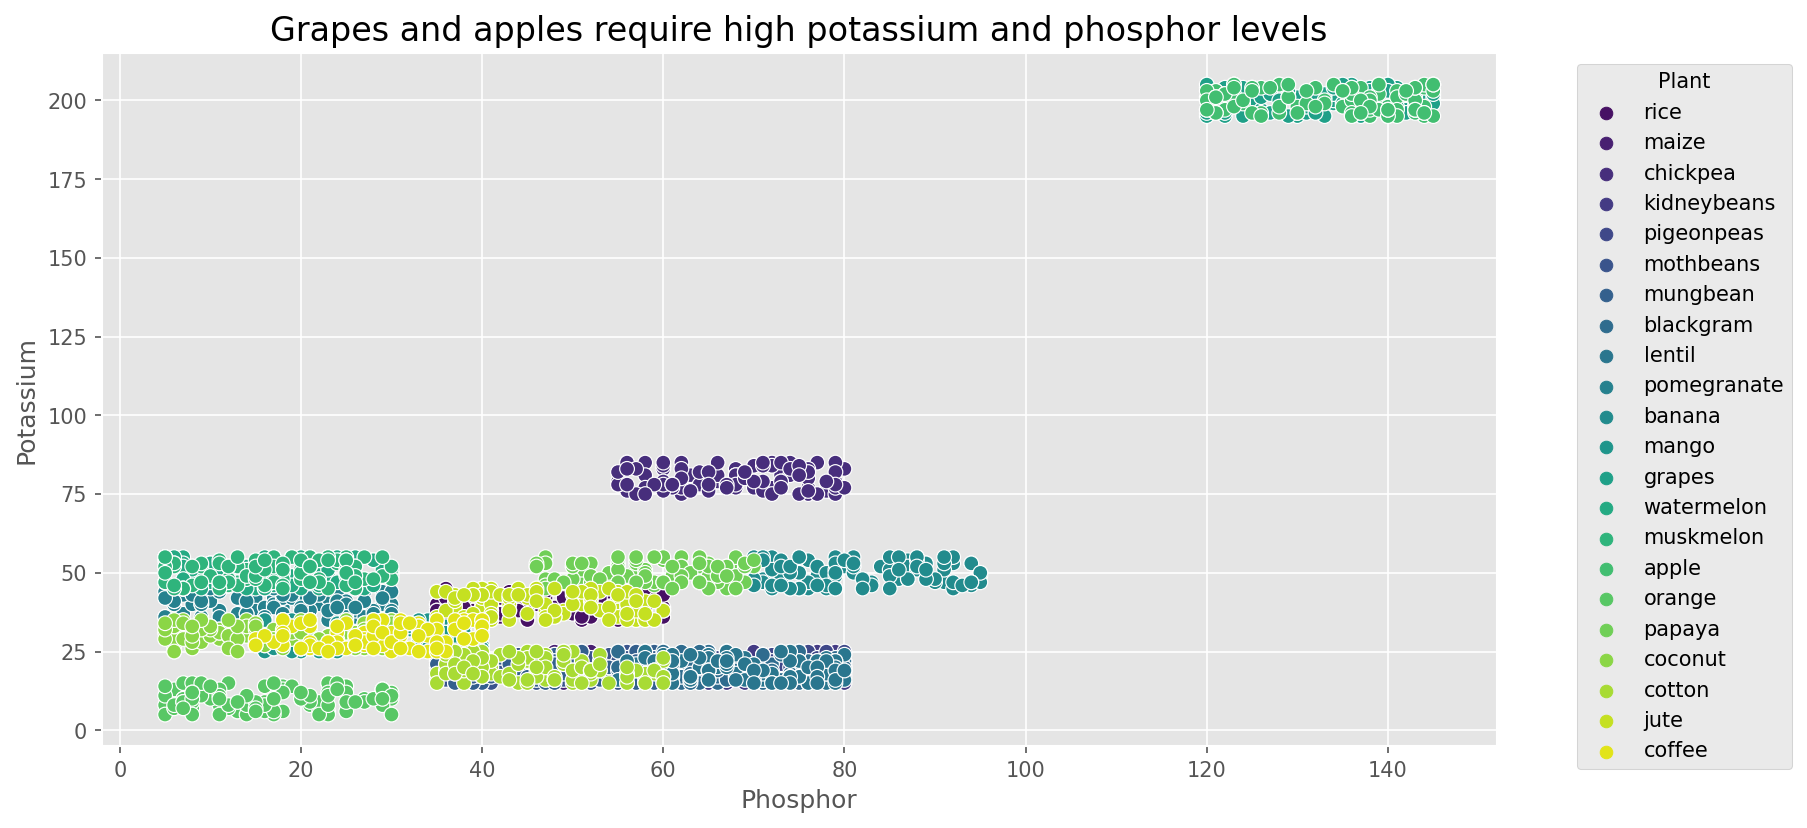

In [596]:
plt.figure(figsize=(12, 6), dpi=150)
sns.scatterplot(x='P', y='K', hue='label', data=data, palette='viridis', s=50)
# square = patches.Rectangle((117,190), width=31, height=20, linewidth=1, edgecolor='red', facecolor='none')
# plt.gca().add_patch(square)
# plt.text(x=132, y=184, s='Grapes & Apples', color='red', fontsize=10, ha='center', va='center')

plt.ylabel('Potassium')
plt.xlabel('Phosphor')
plt.title('Grapes and apples require high potassium and phosphor levels', size=16)
plt.legend(title='Plant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


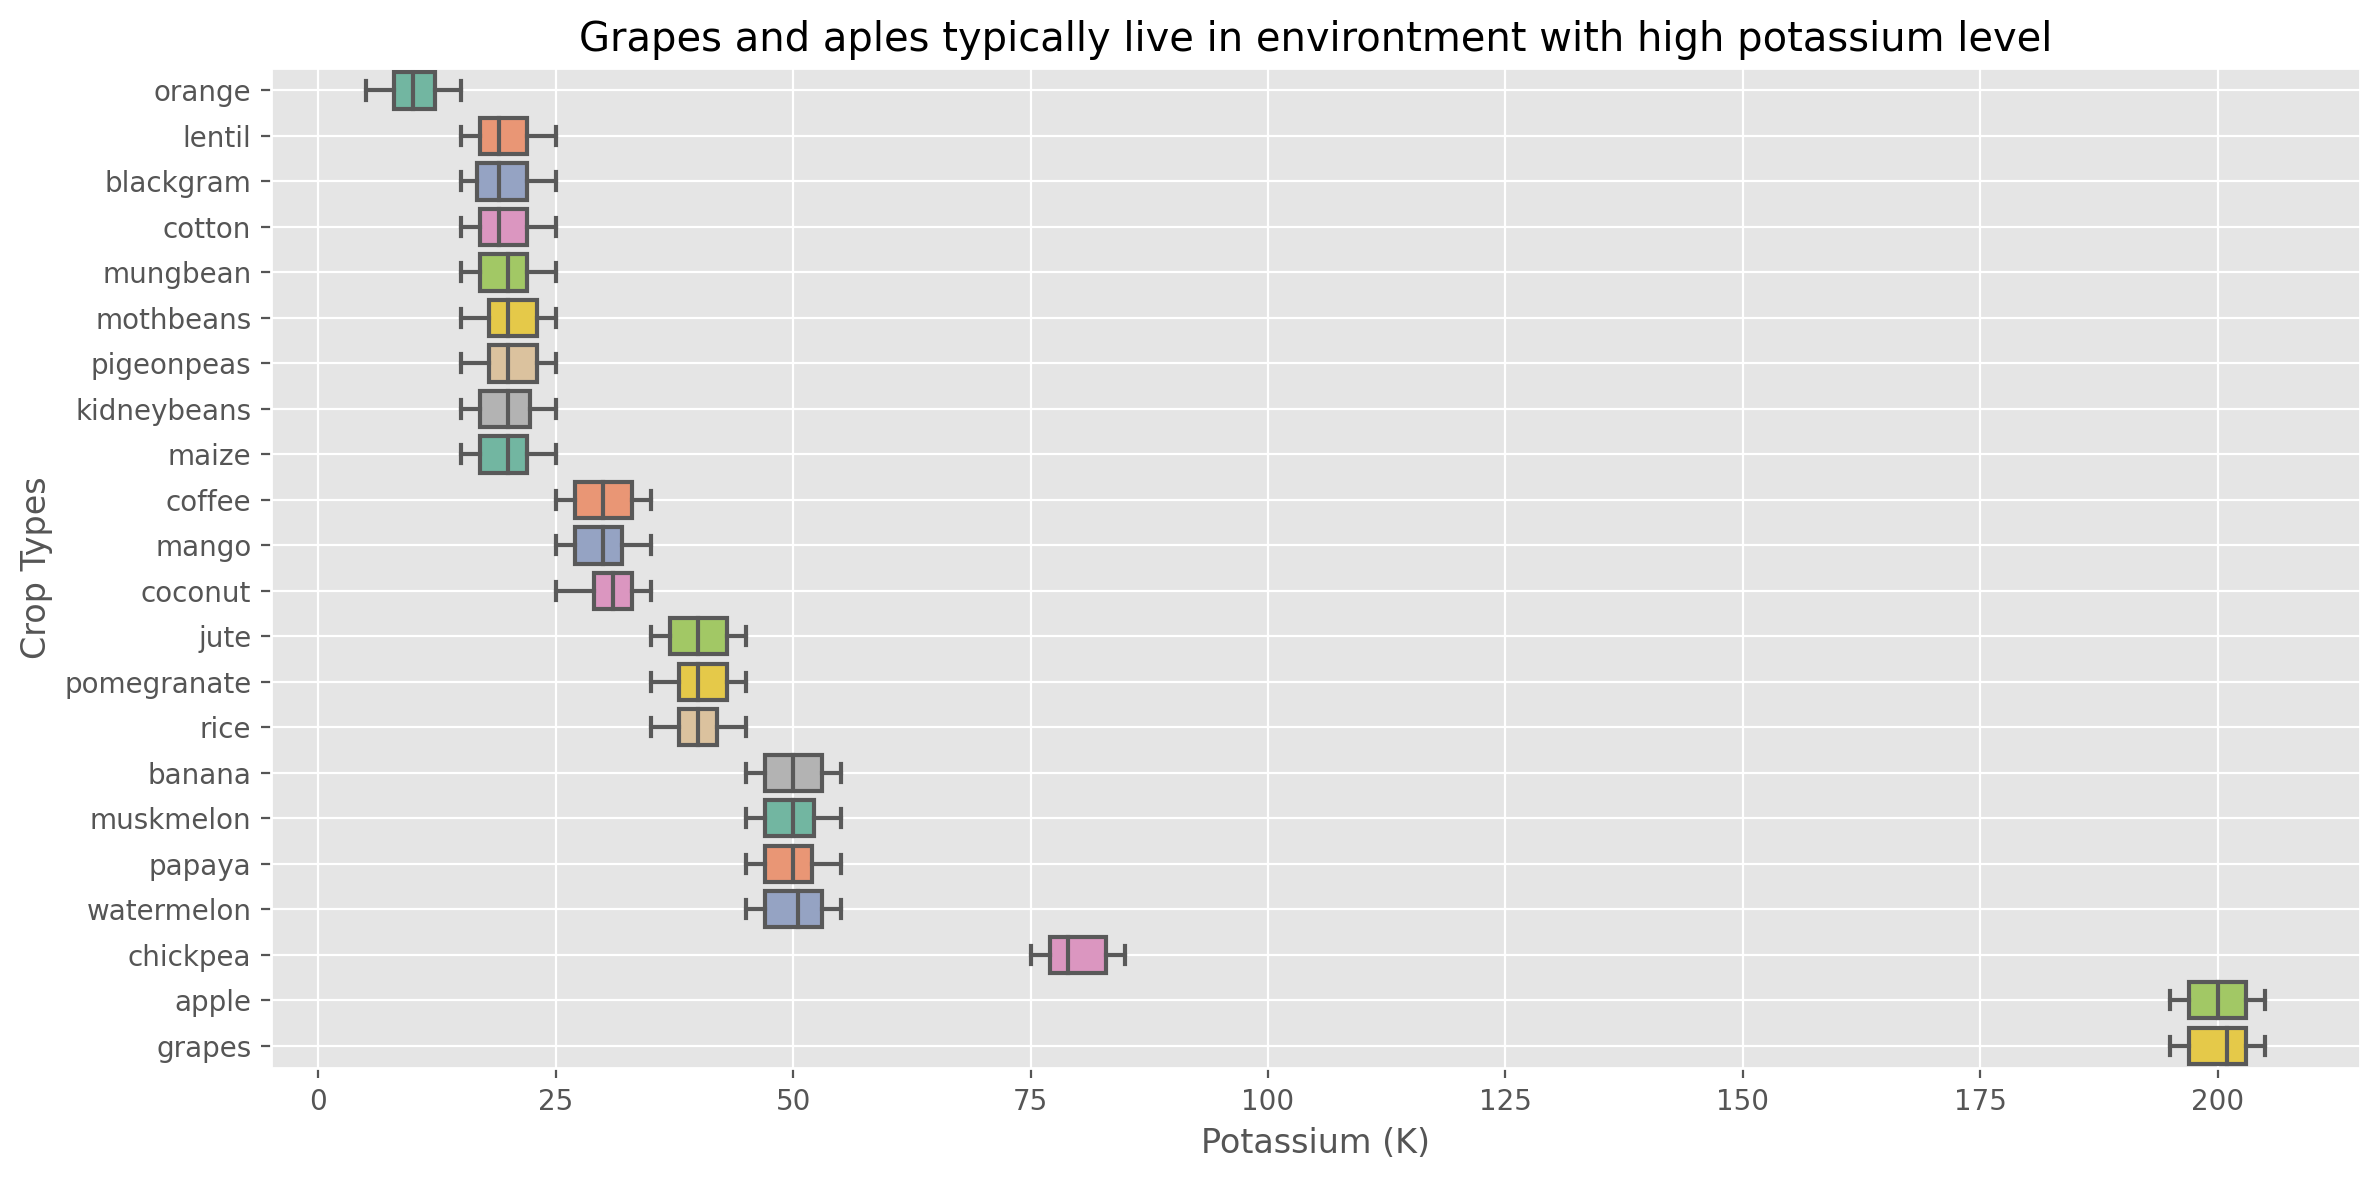

In [597]:
# compare chickpea to other plants
medians = data.groupby('label')['K'].median().sort_values()
sorted_labels = medians.index

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
sns.boxplot(y='label', x='K', data=data, order=sorted_labels, palette='Set2', ax=ax)
ax.grid(True)
plt.title('Grapes and aples typically live in environtment with high potassium level')
ax.set_xlabel('Potassium (K)')
ax.set_ylabel('Crop Types')
plt.tight_layout()
plt.show()

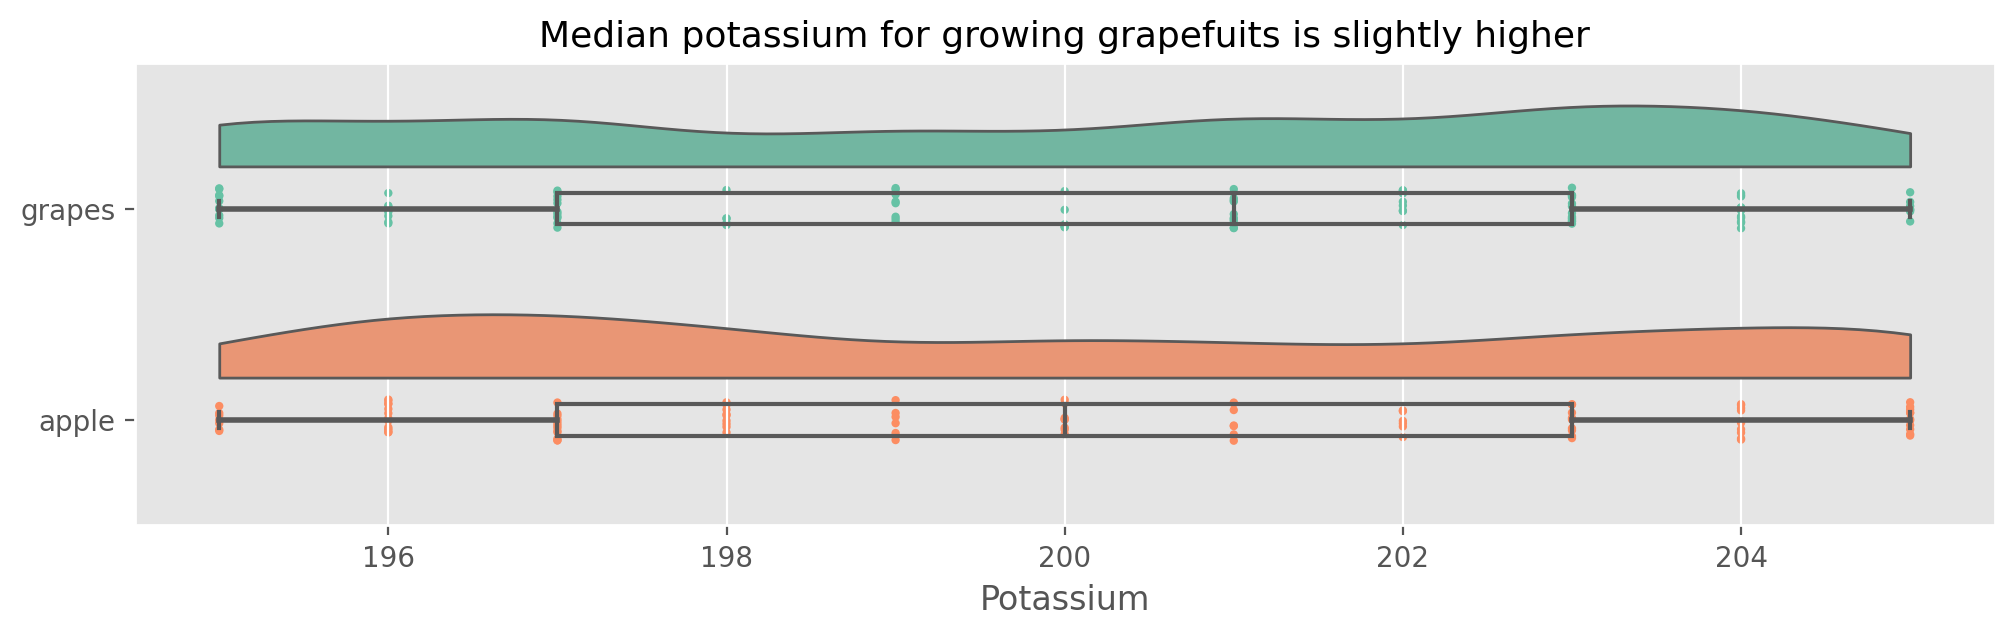

In [598]:
subset_df = data[data['label'].isin(['grapes', 'apple'])]

# set up the figure
plt.figure(figsize=(12, 3), dpi=200)
# use raincloud to display distribution
pt.RainCloud(x='label', y='K', data=subset_df, 
             palette='Set2', bw=.2, width_viol=.6, ax=None, orient='h')
plt.title('Median potassium for growing grapefuits is slightly higher', size=13)
plt.xlabel('Potassium')
plt.ylabel(None)
plt.show()

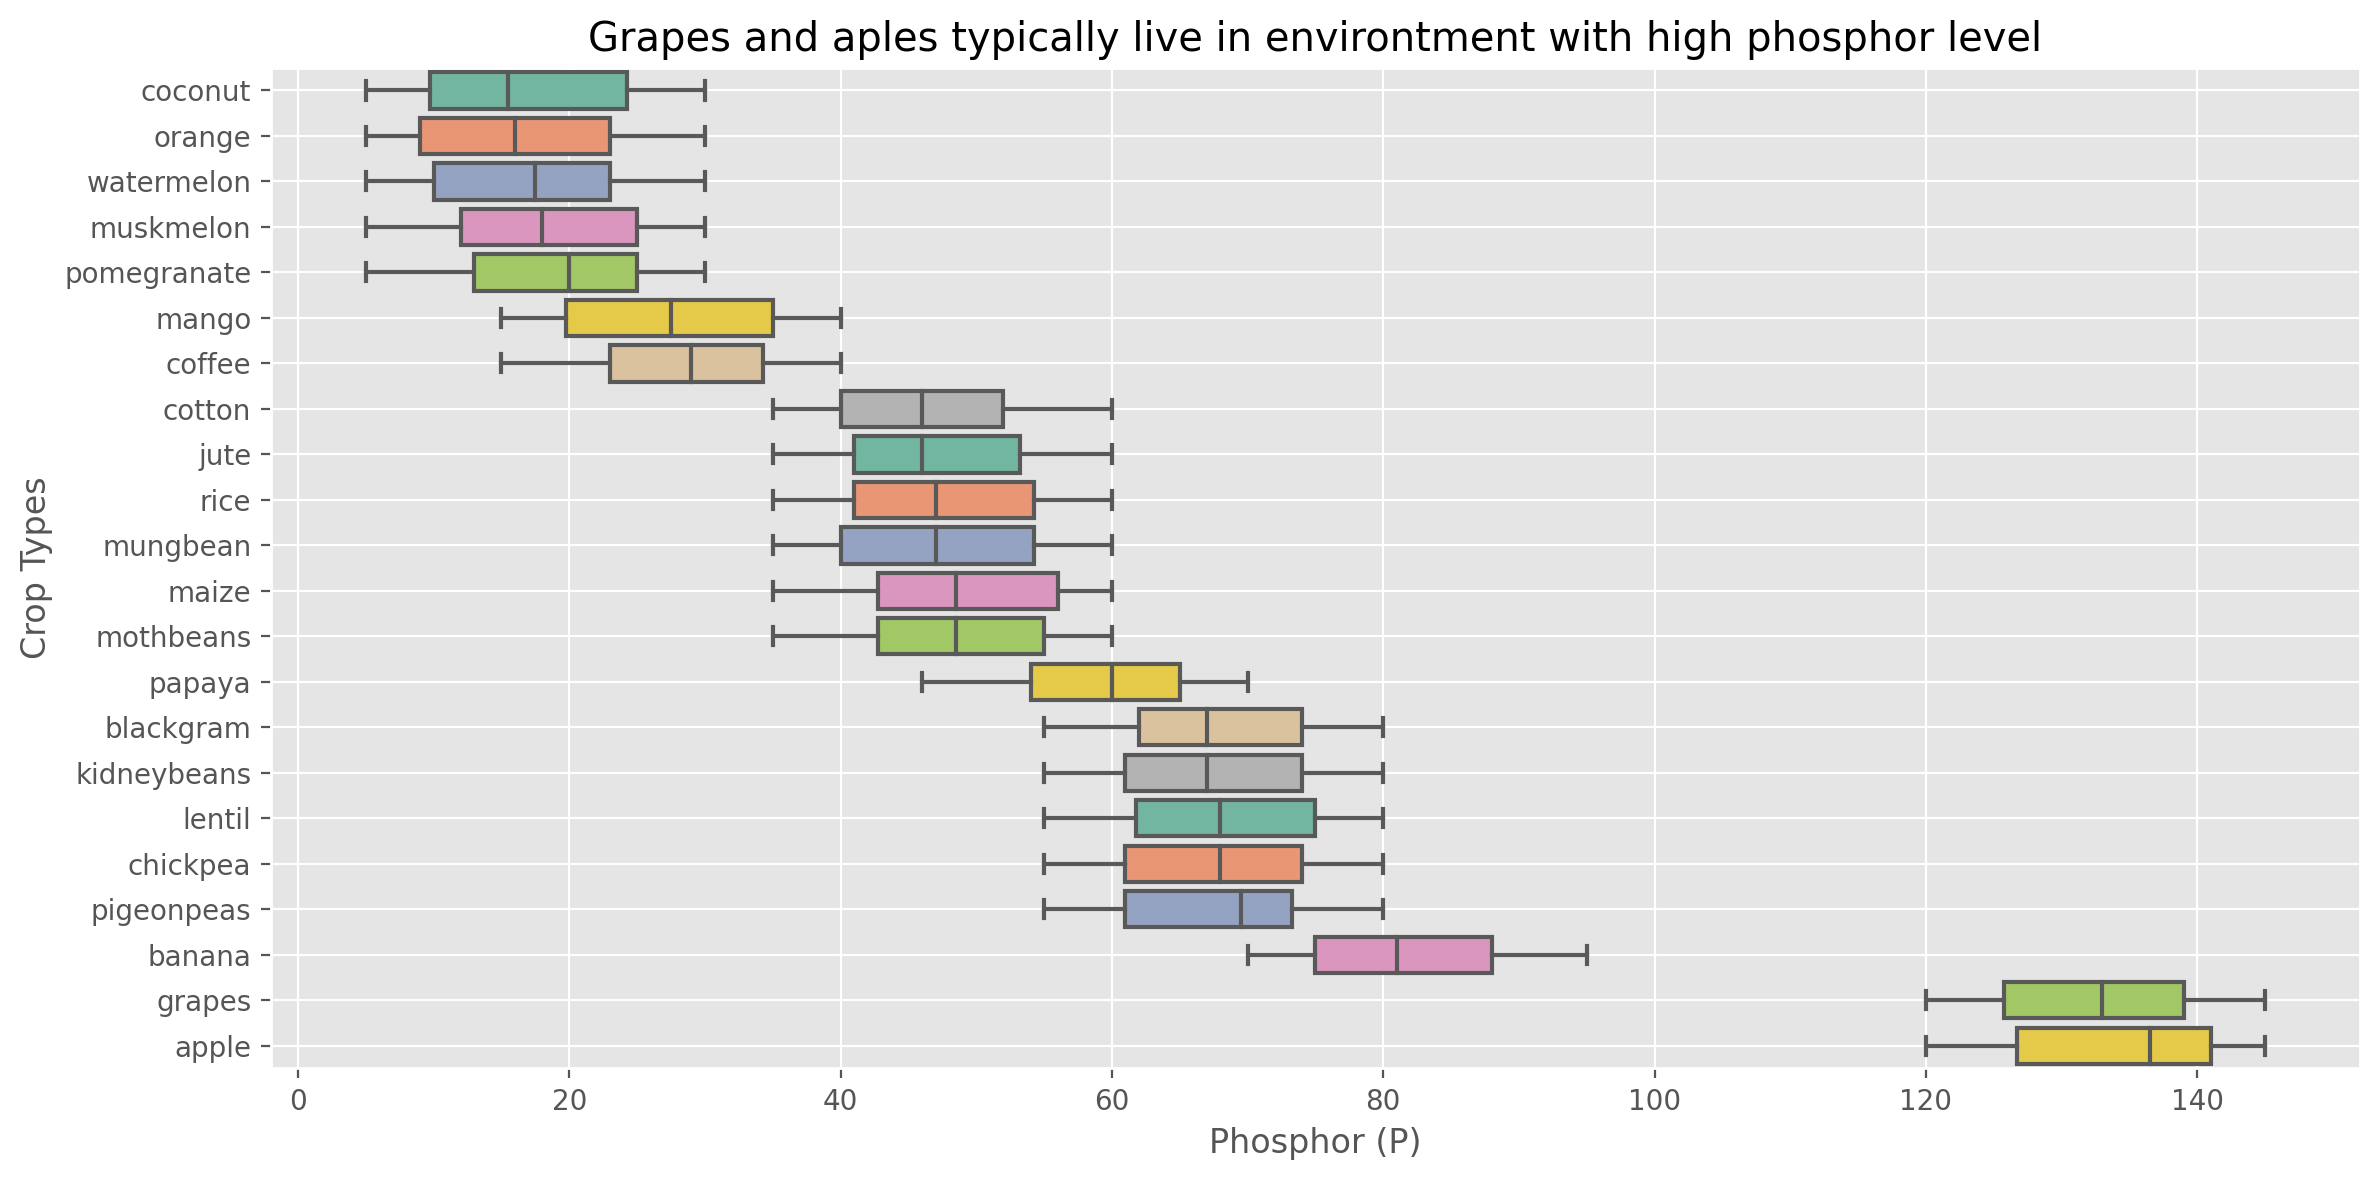

In [599]:
# compare chickpea to other plants
medians = data.groupby('label')['P'].median().sort_values()
sorted_labels = medians.index

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
sns.boxplot(y='label', x='P', data=data, order=sorted_labels, palette='Set2', ax=ax)
ax.grid(True)
plt.title('Grapes and aples typically live in environtment with high phosphor level')
ax.set_xlabel('Phosphor (P)')
ax.set_ylabel('Crop Types')
plt.tight_layout()
plt.show()

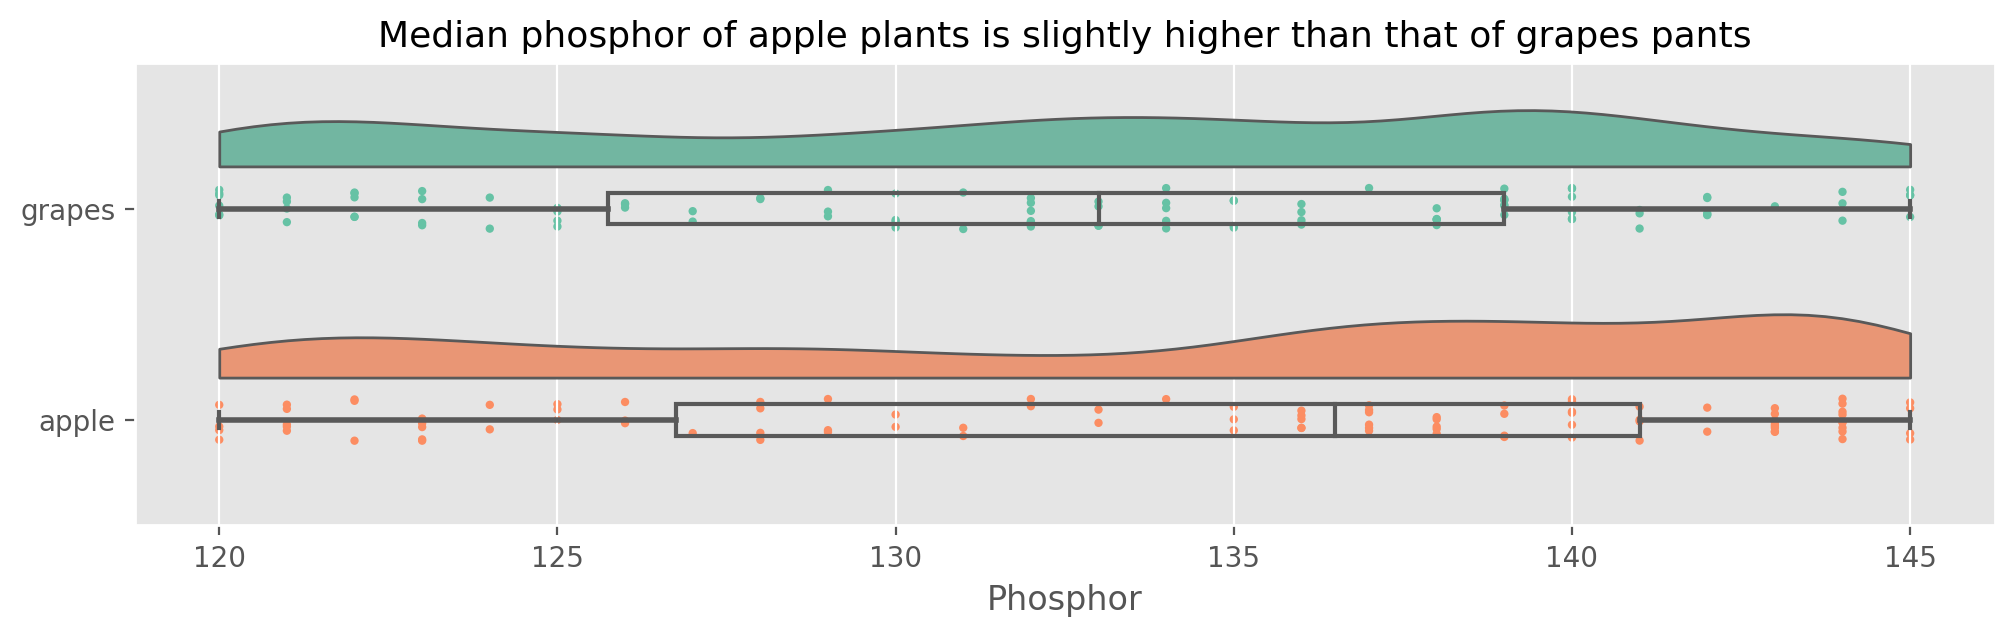

In [600]:
subset_df = data[data['label'].isin(['grapes', 'apple'])]

# set up the figure
plt.figure(figsize=(12, 3), dpi=200)
# use raincloud to display distribution
pt.RainCloud(x='label', y='P', data=subset_df, 
             palette='Set2', bw=.2, width_viol=.6, ax=None, orient='h')
plt.title('Median phosphor of apple plants is slightly higher than that of grapes pants', size=13)
plt.xlabel('Phosphor')
plt.ylabel(None)
plt.show()

#### **3.8.2 Phosphor vs Humidity**

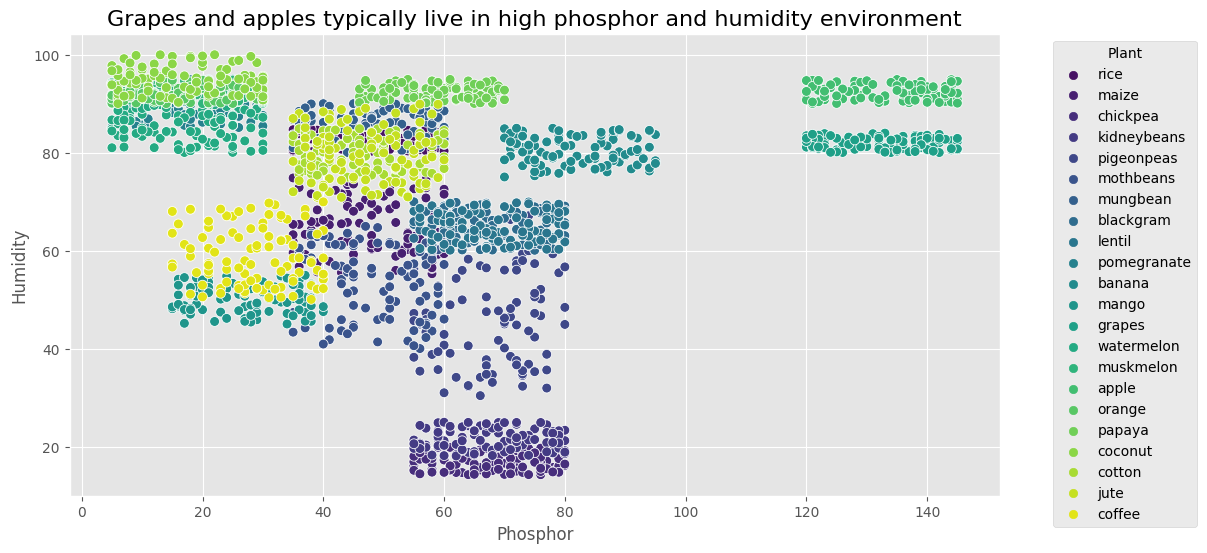

In [601]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='P', y='humidity', hue='label', data=data, palette='viridis', s=50)

plt.ylabel('Humidity')
plt.xlabel('Phosphor')
plt.title('Grapes and apples typically live in high phosphor and humidity environment', size=16)
plt.legend(title='Plant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

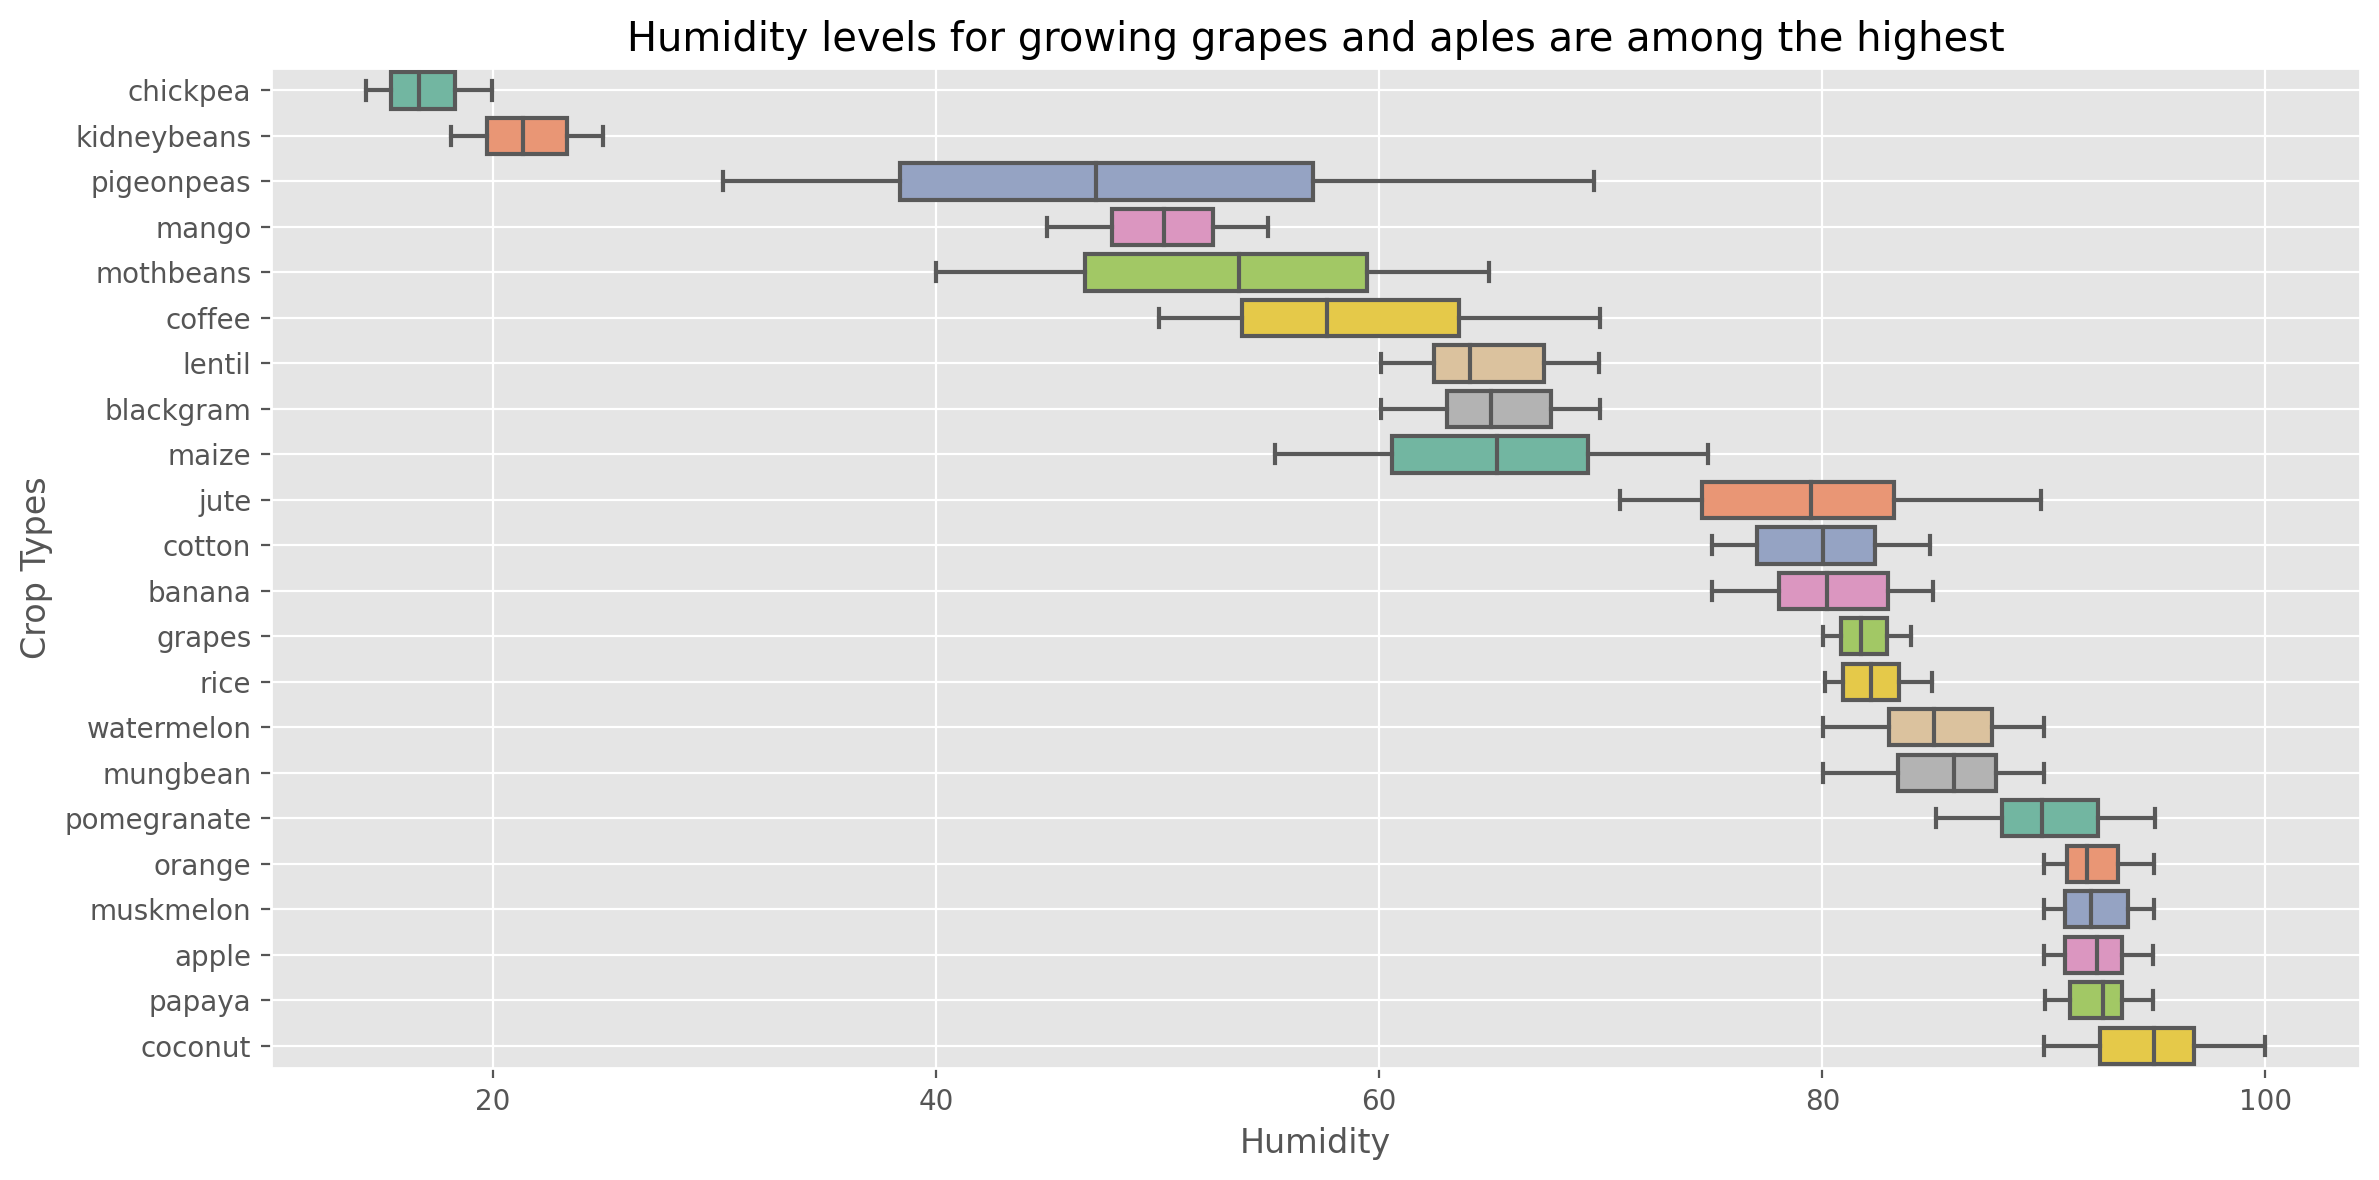

In [602]:
# compare chickpea to other plants
medians = data.groupby('label')['humidity'].median().sort_values()
sorted_labels = medians.index

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
sns.boxplot(y='label', x='humidity', data=data, order=sorted_labels, palette='Set2', ax=ax)
ax.grid(True)
plt.title('Humidity levels for growing grapes and aples are among the highest')
ax.set_xlabel('Humidity')
ax.set_ylabel('Crop Types')
plt.tight_layout()
plt.show()

#### **3.8.3 Potassium vs Humidity**

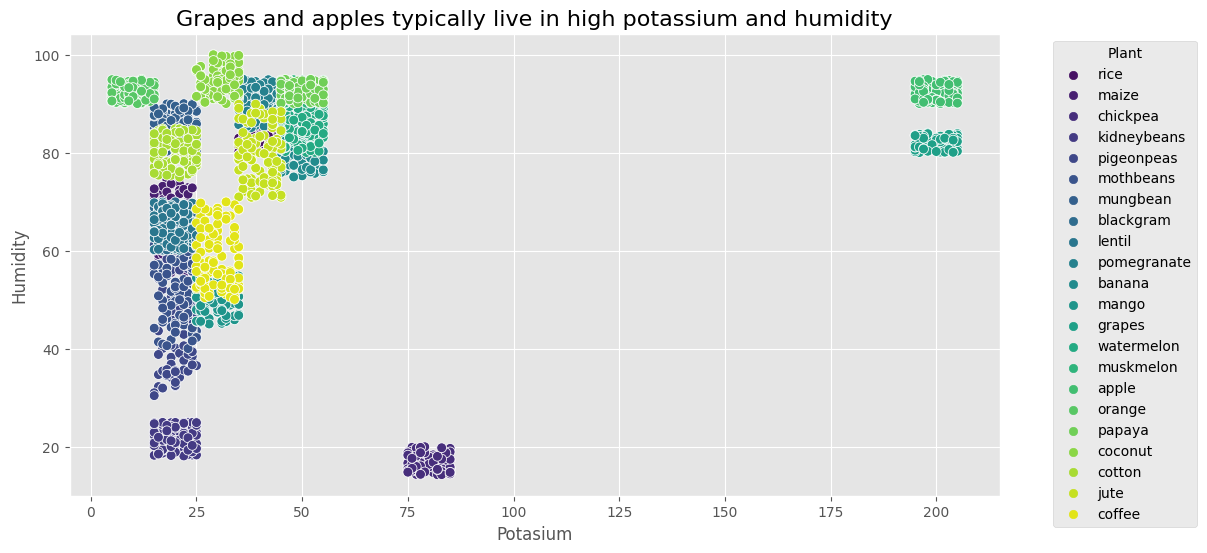

In [603]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='K', y='humidity', hue='label', data=data, palette='viridis', s=50)

plt.ylabel('Humidity')
plt.xlabel('Potasium')
plt.title('Grapes and apples typically live in high potassium and humidity', size=16)
plt.legend(title='Plant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

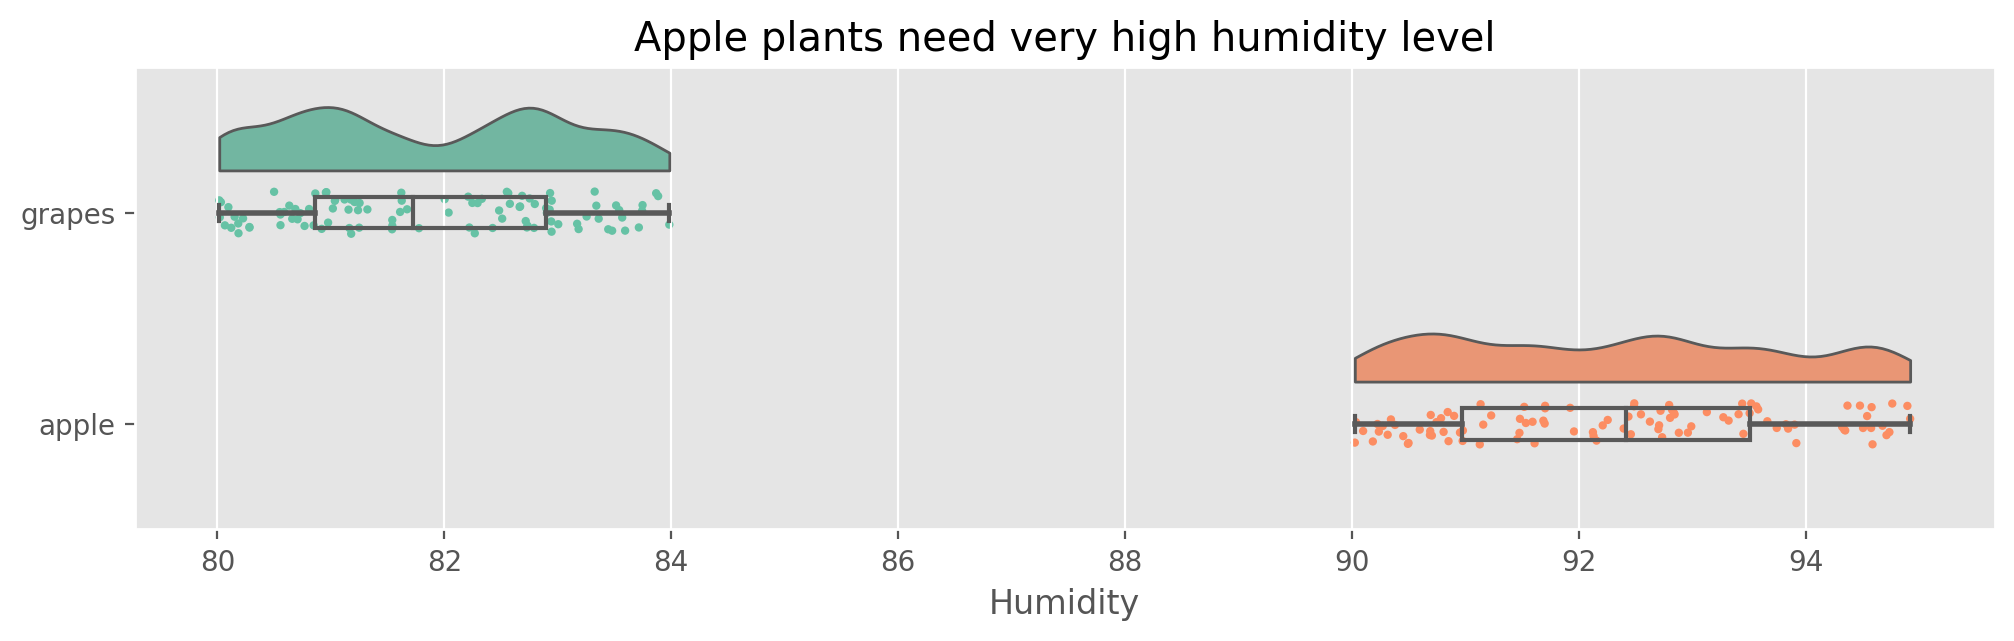

In [604]:
subset_df = data[data['label'].isin(['grapes', 'apple'])]

# set up the figure
plt.figure(figsize=(12, 3), dpi=200)
# use raincloud to display distribution
pt.RainCloud(x='label', y='humidity', data=subset_df, 
             palette='Set2', bw=.2, width_viol=.6, ax=None, orient='h')
plt.title('Apple plants need very high humidity level')
plt.xlabel('Humidity')
plt.ylabel(None)
plt.show()

#### **3.8.4 Nitrogen vs Potassium**

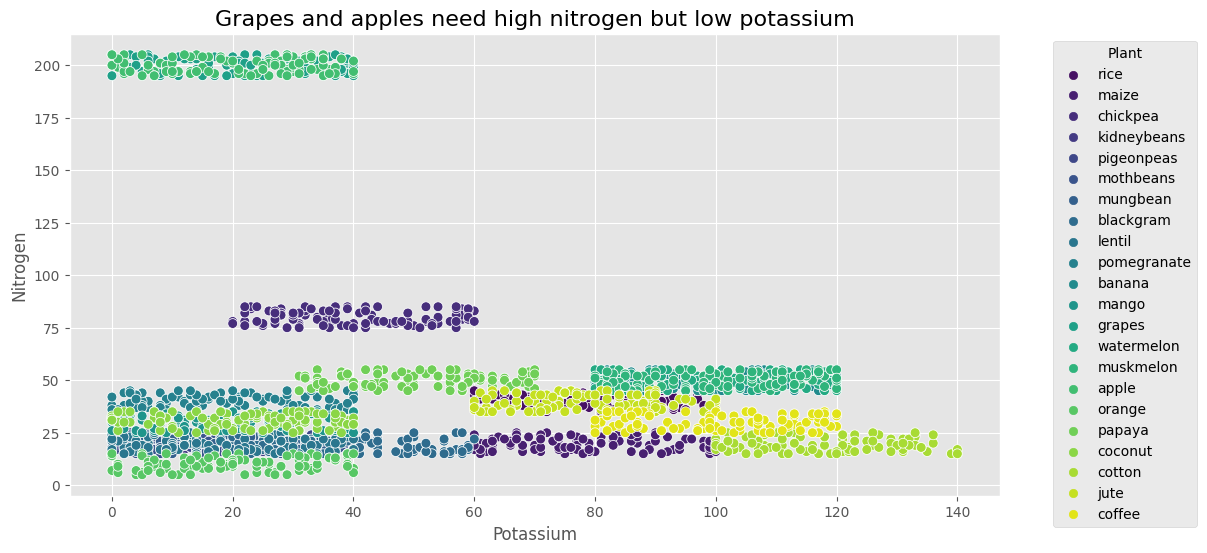

In [605]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='N', y='K', hue='label', data=data, palette='viridis', s=50)

plt.ylabel('Nitrogen')
plt.xlabel('Potassium')
plt.title('Grapes and apples need high nitrogen but low potassium', size=16)
plt.legend(title='Plant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

paling tinggis: Phosphor vs humidity; Potassium vs humidity; Nitrogen vs Potassium

#### **Phosphor vs Humidity**

In [606]:
data.groupby('label', as_index=False)[['P', 'K']].corr(method='spearman').round(2).transpose().style.background_gradient(cmap='YlOrRd').format('{:.2f}')

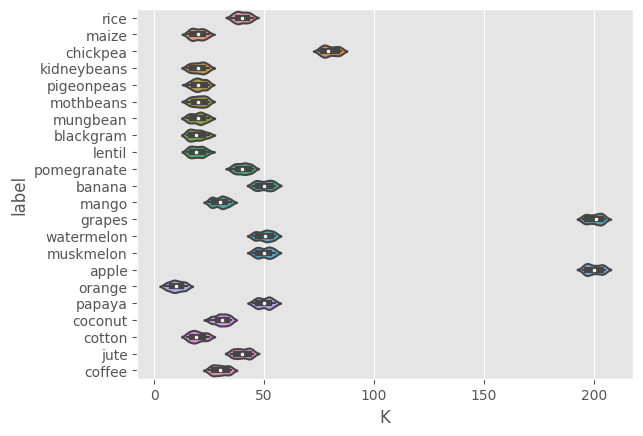

In [607]:

sns.violinplot(y='label', x='K', data=data)
plt.show()

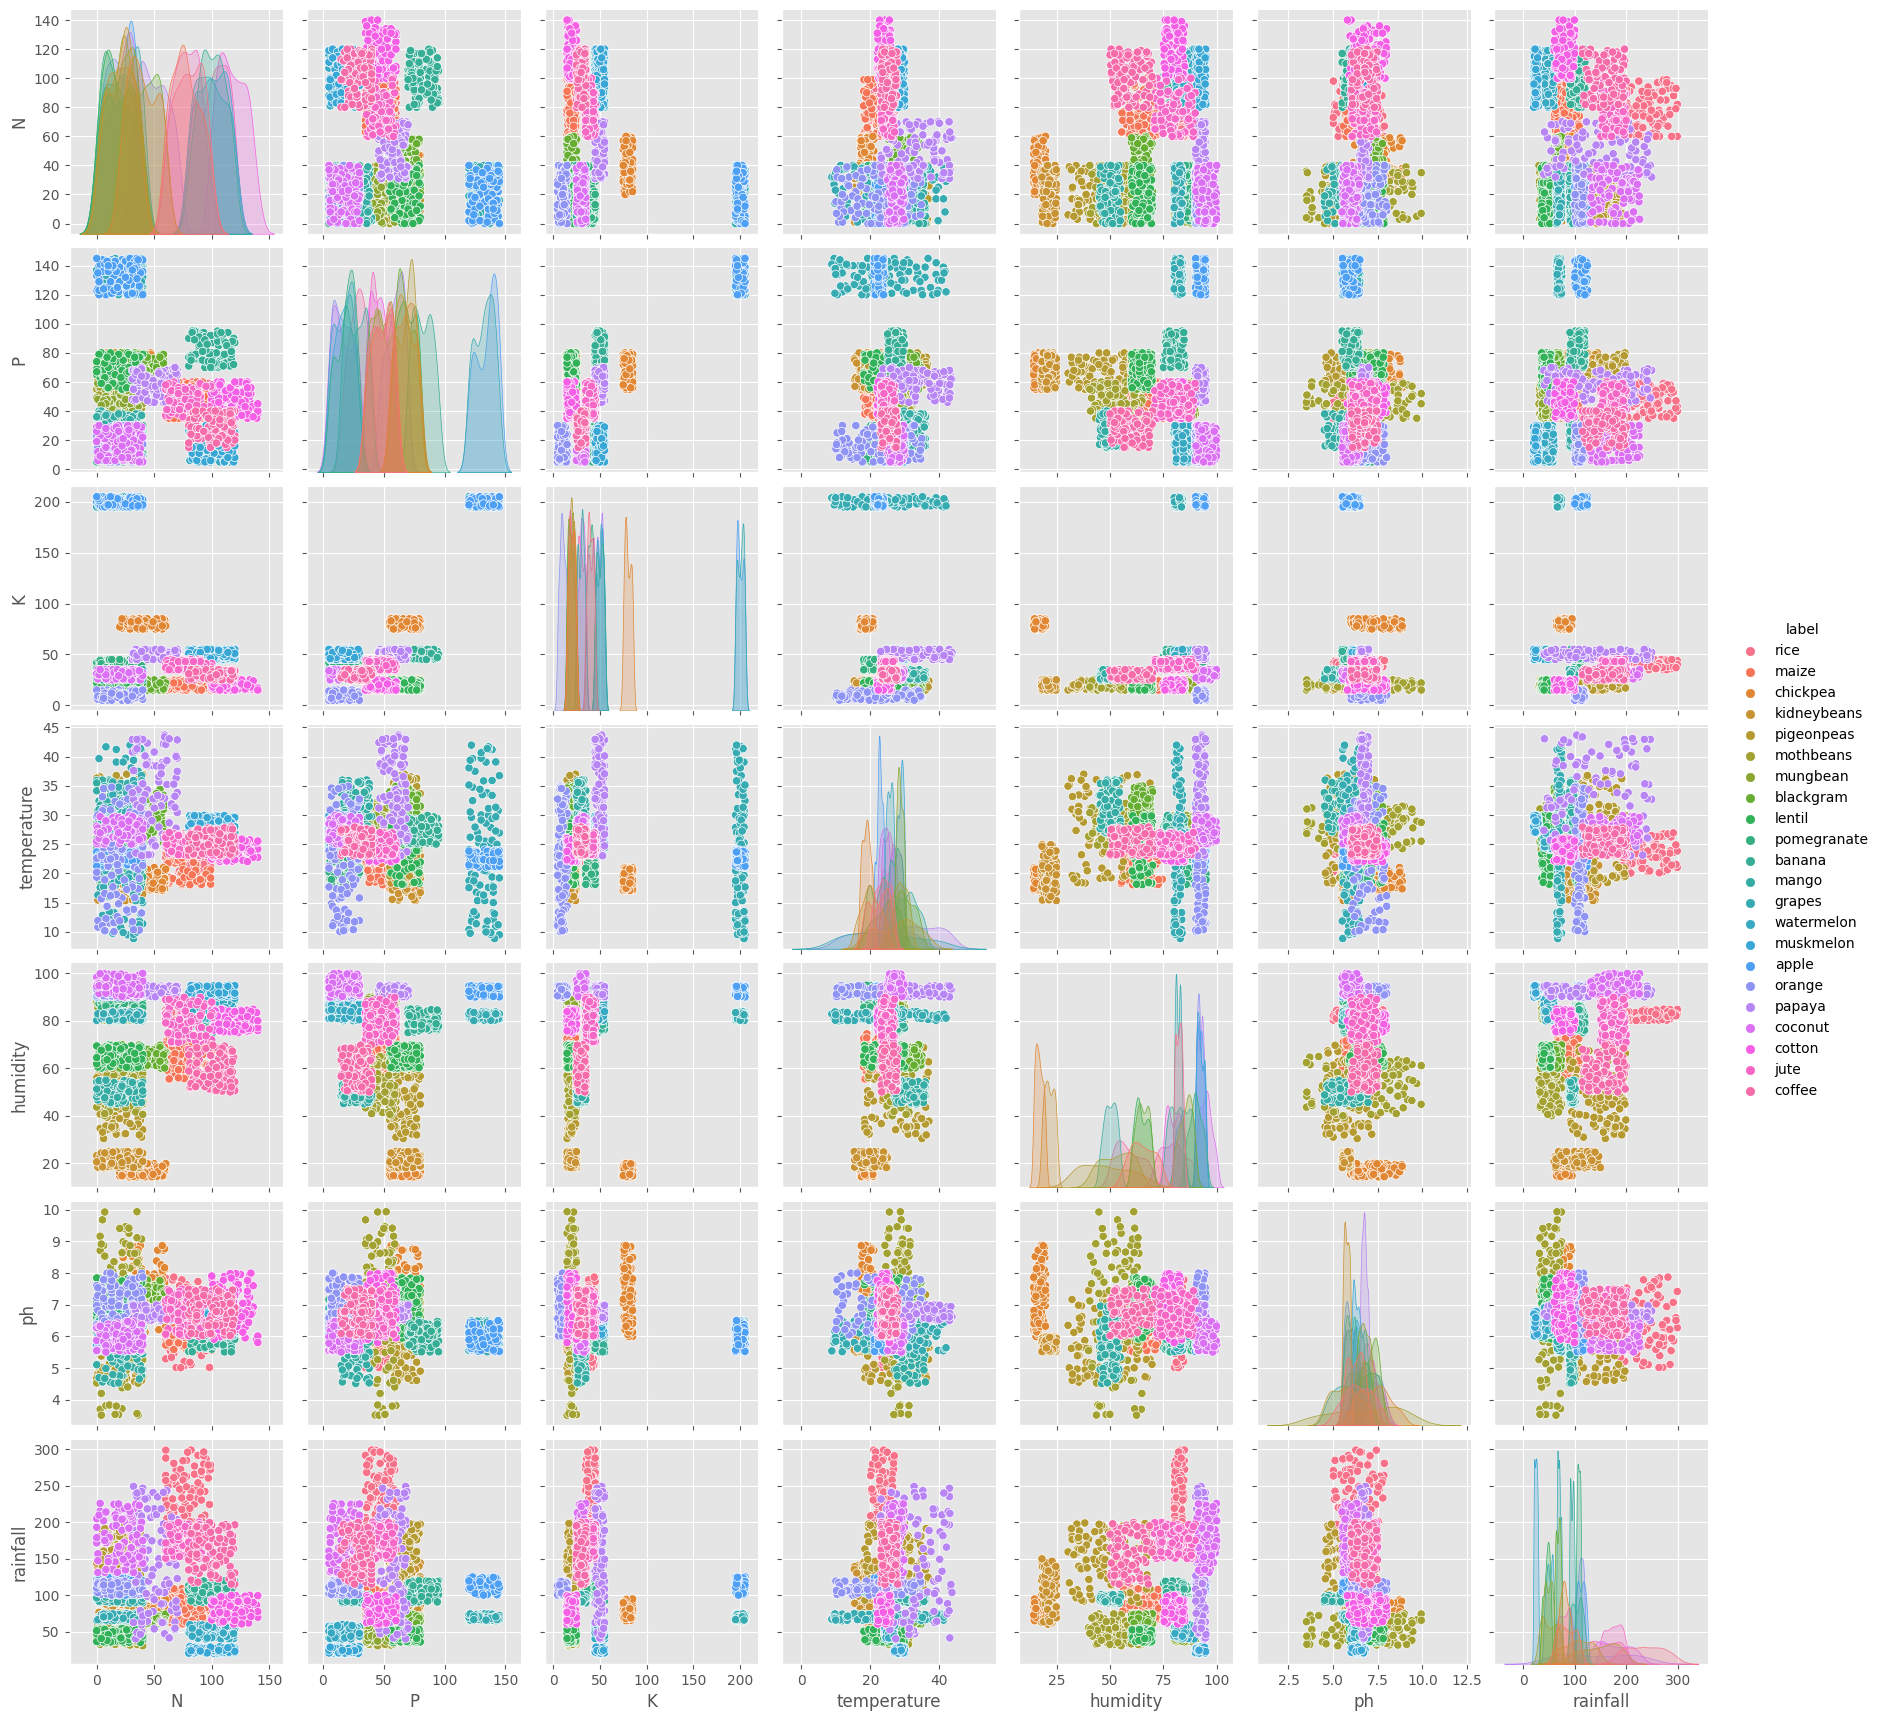

In [608]:
sns.pairplot(data, hue='label', diag_kind='kde')

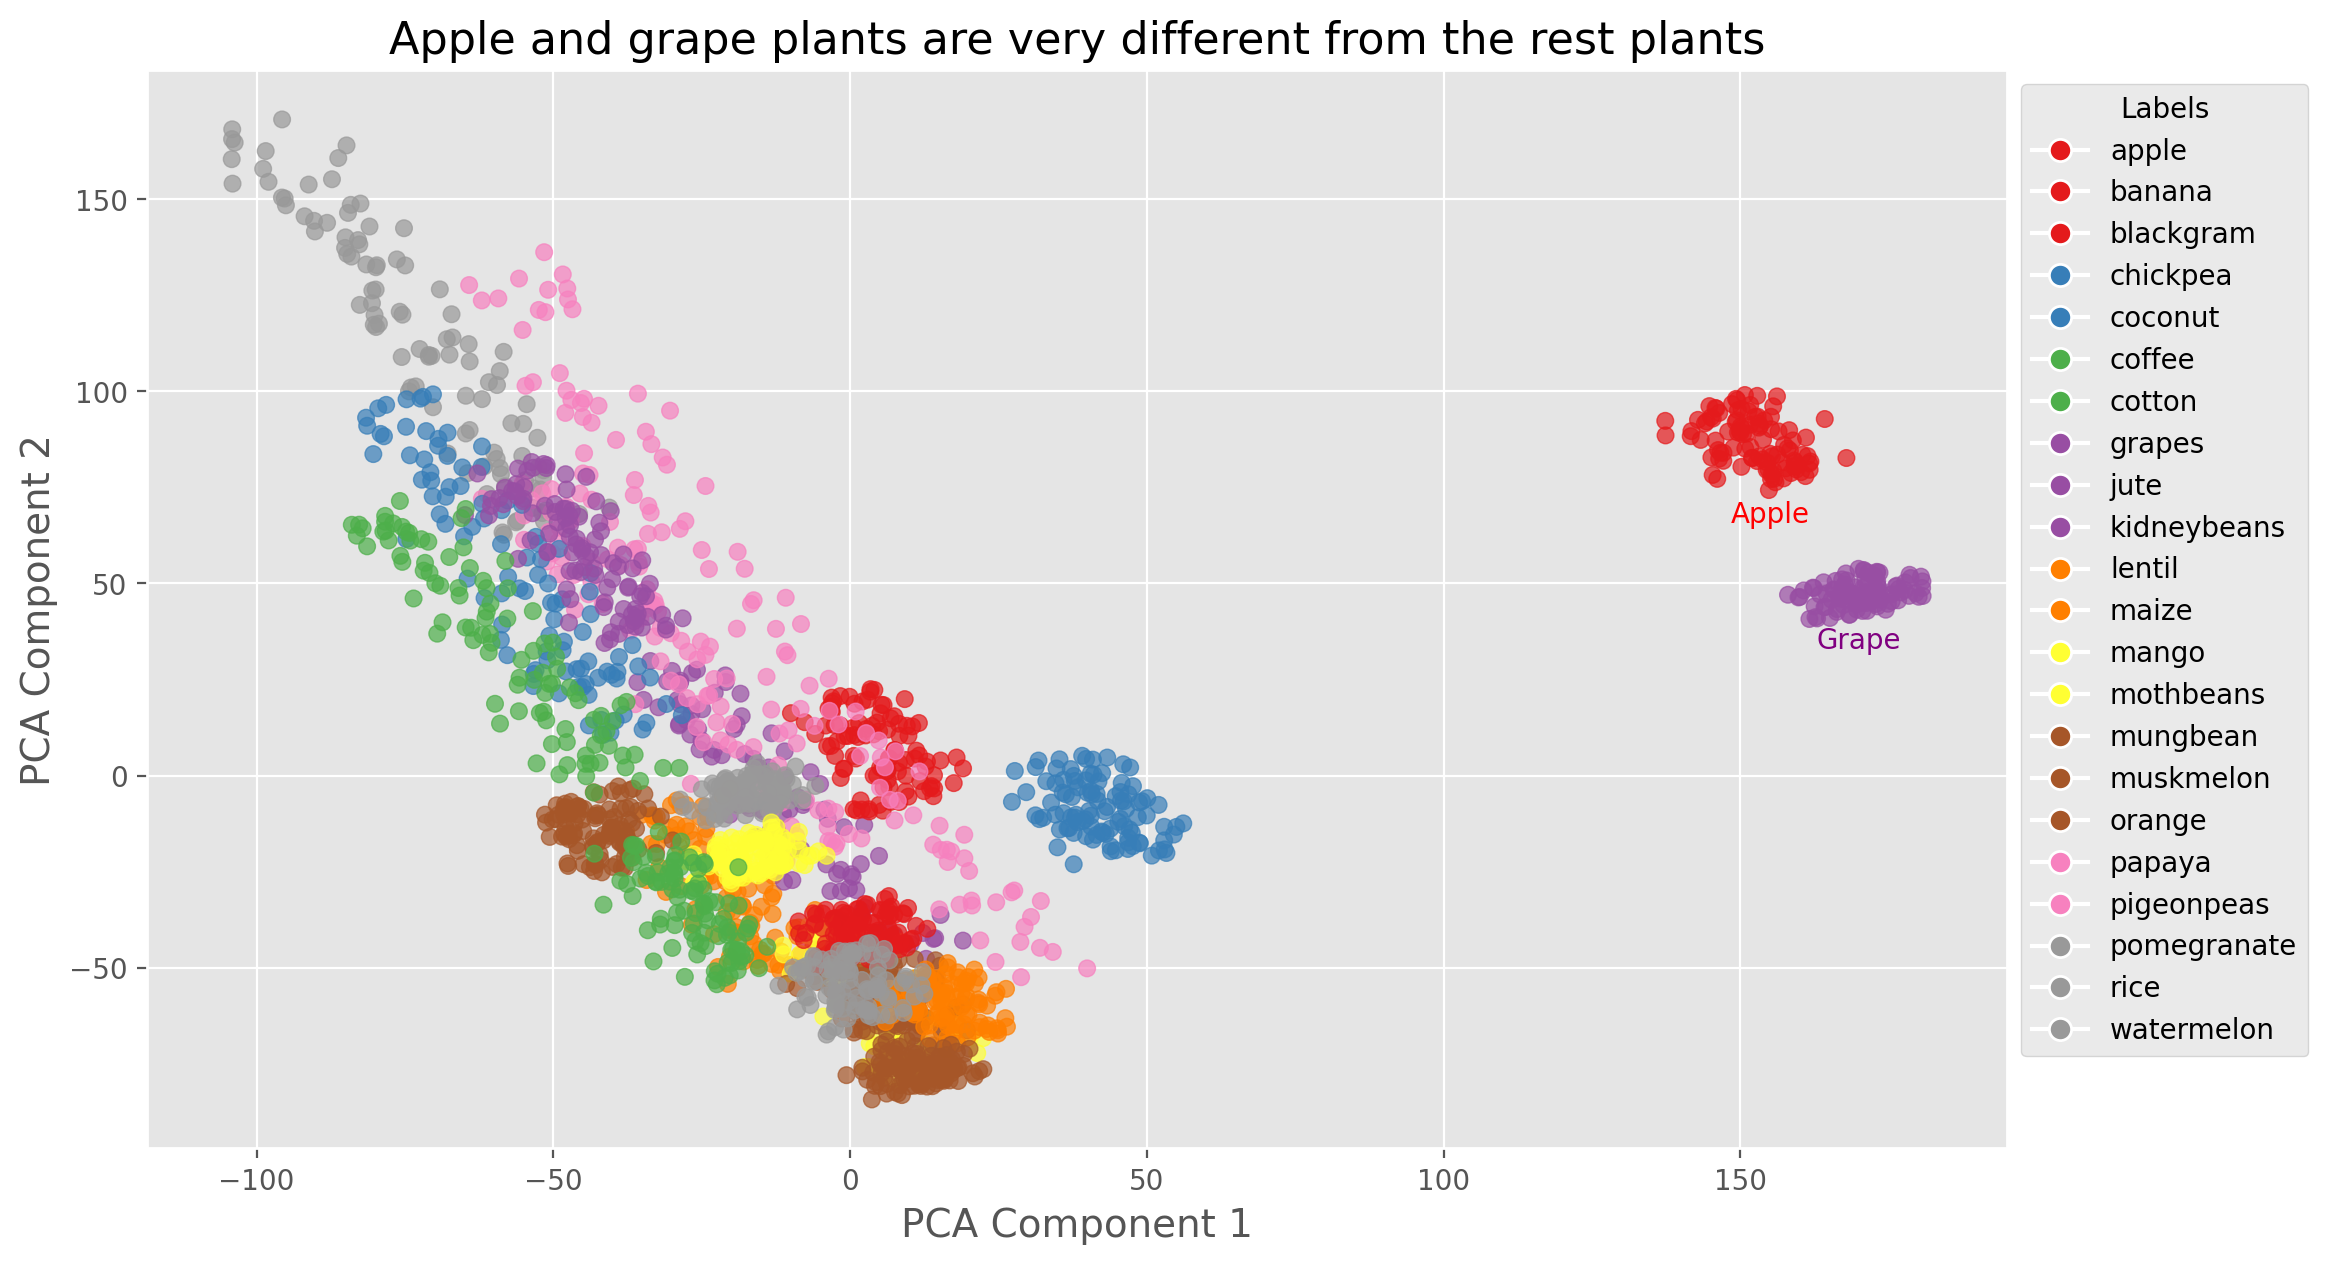

In [609]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data['label'])

# Prepare the data for PCA
X = data.select_dtypes(include='number')
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Plot using the encoded label
plt.figure(figsize=(12, 7), dpi=200)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=encoded_labels, cmap='Set1', alpha=0.7)
# plt.colorbar(scatter)  # Show color bar
plt.title('Apple and grape plants are very different from the rest plants', size=16)
plt.xlabel('PCA Component 1', size=14)
plt.ylabel('PCA Component 2', size=14)

# Add a legend
unique_encoded_labels = np.unique(encoded_labels)
legend_labels = label_encoder.inverse_transform(unique_encoded_labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8) for i in unique_encoded_labels]
plt.text(x=155, y=68, s='Apple', color='red', fontsize=10, ha='center', va='center')
plt.text(x=170, y=35, s='Grape', color='purple', fontsize=10, ha='center', va='center')
plt.legend(handles, legend_labels, title='Labels', bbox_to_anchor=(1, 1))
plt.show()

## **4 Predictive Modeling**

In [709]:
data = pd.read_csv('../data/Crop_recommendation.csv')

In [710]:
# Encode the categorical label
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Define features and target
X = data.drop(columns=['label'])
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'The X_train consists of {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'The y_train consists of {y_train.shape[0]} rows')
print(f'X_test consists of {X_test.shape[0]} rows and {X_test.shape[1]} columns')
print(f'The y_test consists of {y_test.shape[0]} rows')

The X_train consists of 1760 rows and 7 columns
The y_train consists of 1760 rows
X_test consists of 440 rows and 7 columns
The y_test consists of 440 rows


In [711]:
X_train

N    P    K  temperature   humidity        ph    rainfall
1656   17   16   14    16.396243  92.181519  6.625539  102.944161
752    37   79   19    27.543848  69.347863  7.143943   69.408782
892     7   73   25    27.521856  63.132153  7.288057   45.208411
1041  101   70   48    25.360592  75.031933  6.012697  116.553145
1179    0   17   30    35.474783  47.972305  6.279134   97.790725
...   ...  ...  ...          ...        ...       ...         ...
1638   10    5    5    21.213070  91.353492  7.817846  112.983436
1095  108   94   47    27.359116  84.546250  6.387431   90.812505
1130   11   36   31    27.920633  51.779659  6.475449  100.258567
1294   11  124  204    13.429886  80.066340  6.361141   71.400430
860    32   78   22    23.970814  62.355576  7.007038   53.409060

[1760 rows x 7 columns]

In [712]:
y_train

1656    16
752      2
892     10
1041     1
1179    12
        ..
1638    16
1095     1
1130    12
1294     7
860     10
Name: label, Length: 1760, dtype: int64

In [713]:
# data2 = data.copy()
# interpret_label =(data2[['label', 'label_enc']]
#                   .drop_duplicates(keep='first')
#                   .sort_values(by='label_enc'))
# interpret_label

In [714]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

In [720]:
# Preprocessor pipeline (here we're just using a standard scaler as an example)
num_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols)
], remainder='passthrough')
display(preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', RobustScaler(),
                                 ['N', 'P', 'K', 'temperature', 'humidity',
                                  'ph', 'rainfall'])])

In [721]:
# Specify models for comparison
classifiers = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('CatBoost', CatBoostClassifier(verbose=0, random_state=42))
]

# Assemble everything in a pipeline
pipelines = [(name, Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])) for name, model in classifiers]

# Scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Using macro because the distribution of classes in the target variable is balanced. It treats each class equally.

### **4.1 Model Comparison**

In [722]:
# evaluate each model
results = []
for name, pipeline in pipelines:
    scores = {}
    start_time = time.time()
    for metric_name, scorer in scoring.items():
        cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, 
                                    scoring=scorer, n_jobs=-1)
        scores[f"{metric_name}"] = np.mean(cv_results['test_score'])
        scores[f"{metric_name}_sd"] = np.std(cv_results['test_score'])
    end_time = time.time()
    training_time = end_time - start_time
    scores['training_time'] = training_time
    results.append((name, scores))

# show in df
results_df = pd.DataFrame(results, columns=['Model', 'Scores'])
scores_df = results_df['Scores'].apply(pd.Series)
results_df = pd.concat([results_df[['Model']], scores_df], axis=1).round(3)
results_df = results_df.set_index('Model')

In [723]:
# display comparison output
results_df.sort_values(by=['f1', 'precision', 'recall'], ascending=False)

accuracy  accuracy_sd  precision  precision_sd  \
Model                                                                    
Random Forest              0.994        0.003      0.994         0.003   
CatBoost                   0.993        0.003      0.994         0.002   
Gradient Boosting          0.990        0.001      0.991         0.001   
XGBoost                    0.985        0.002      0.986         0.002   
Decision Tree              0.985        0.005      0.986         0.004   
K-Nearest Neighbors        0.982        0.005      0.985         0.004   
Support Vector Machine     0.982        0.008      0.985         0.007   
Logistic Regression        0.947        0.007      0.953         0.008   
AdaBoost                   0.165        0.022      0.082         0.012   

                        recall  recall_sd     f1  f1_sd  training_time  
Model                                                                   
Random Forest            0.994      0.003  0.994  0.003          0.886  
CatBoost                 0.993      0.003  0.993  0.003         68.621  
Gradient Boosting        0.990      0.001  0.990  0.001         22.120  
XGBoost                  0.985      0.002  0.985  0.002          0.777  
Decision Tree            0.984      0.005  0.984  0.005          0.911  
K-Nearest Neighbors      0.982      0.005  0.982  0.005          0.113  
Support Vector Machine   0.982      0.008  0.982  0.008          0.764  
Logistic Regression      0.946      0.008  0.945  0.008          0.362  
AdaBoost                 0.155      0.022  0.094  0.016          0.501

### **4.2 Model Creation**

In [745]:
# build pipelines
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
display(rf_score_df)

Fold  Train Accuracy  Test Accuracy  Train F1 Score  Test F1 Score  \
0     1             1.0       0.997159             1.0       0.997159   
1     2             1.0       0.988636             1.0       0.988586   
2     3             1.0       0.991477             1.0       0.991467   
3     4             1.0       0.997159             1.0       0.997159   
4     5             1.0       0.994318             1.0       0.994318   

   Train Recall  Test Recall  Train Precision  Test Precision        TT  
0           1.0     0.997159              1.0        0.997337  0.194683  
1           1.0     0.988636              1.0        0.990149  0.146208  
2           1.0     0.991477              1.0        0.991627  0.146940  
3           1.0     0.997159              1.0        0.997337  0.146296  
4           1.0     0.994318              1.0        0.994673  0.148786

In [746]:
# perform cross-validation
cv_results = cross_validate(rf_clf, X_train, y_train, cv=skf, scoring=scoring, return_train_score=True)

# store results in df
dt_score_df = pd.DataFrame({
    'Fold': range(1, skf.get_n_splits() + 1),
    'Train Accuracy': cv_results['train_accuracy'],
    'Test Accuracy': cv_results['test_accuracy'],
    'Train F1 Score': cv_results['train_f1'],
    'Test F1 Score': cv_results['test_f1'],
    'Train Recall': cv_results['train_recall'],
    'Test Recall': cv_results['test_recall'],
    'Train Precision': cv_results['train_precision'],
    'Test Precision': cv_results['test_precision'],
    'TT': cv_results['fit_time']
})

# Calculate and add mean and standard deviation to the DataFrame
mean_accuracy = dt_score_df['Test Accuracy'].mean()
std_accuracy = dt_score_df['Test Accuracy'].std()
mean_f1 = dt_score_df['Test F1 Score'].mean()
std_f1 = dt_score_df['Test F1 Score'].std()
mean_recall = dt_score_df['Test Recall'].mean()
std_recall = dt_score_df['Test Recall'].std()
mean_precision = dt_score_df['Test Precision'].mean()
std_precision = dt_score_df['Test Precision'].std()
mean_tt = dt_score_df['TT'].mean()
std_tt = dt_score_df['TT'].std()

# Display the results
display(dt_score_df.round(4))
print("\nMean test accuracy: {:.4f} (Std: {:.4f})".format(mean_accuracy, std_accuracy))
print("Mean test F1 score: {:.4f} (Std: {:.4f})".format(mean_f1, std_f1))
print("Mean test recall: {:.4f} (Std: {:.4f})".format(mean_recall, std_recall))
print("Mean test recall: {:.4f} (Std: {:.4f})".format(mean_precision, std_precision))
print("Mean training time: {:.4f} (Std: {:.4f})".format(mean_tt, std_tt))

Fold  Train Accuracy  Test Accuracy  Train F1 Score  Test F1 Score  \
0     1             1.0         0.9972             1.0         0.9971   
1     2             1.0         0.9886             1.0         0.9889   
2     3             1.0         0.9915             1.0         0.9915   
3     4             1.0         0.9972             1.0         0.9971   
4     5             1.0         0.9943             1.0         0.9941   

   Train Recall  Test Recall  Train Precision  Test Precision      TT  
0           1.0       0.9972              1.0          0.9972  0.2306  
1           1.0       0.9891              1.0          0.9901  0.1877  
2           1.0       0.9913              1.0          0.9919  0.1502  
3           1.0       0.9972              1.0          0.9972  0.1486  
4           1.0       0.9943              1.0          0.9943  0.1468


Mean test accuracy: 0.9938 (Std: 0.0037)
Mean test F1 score: 0.9937 (Std: 0.0036)
Mean test recall: 0.9938 (Std: 0.0036)
Mean test recall: 0.9941 (Std: 0.0031)
Mean training time: 0.1728 (Std: 0.0365)


In [747]:
# evaluate the model
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14
      papaya       1.00    

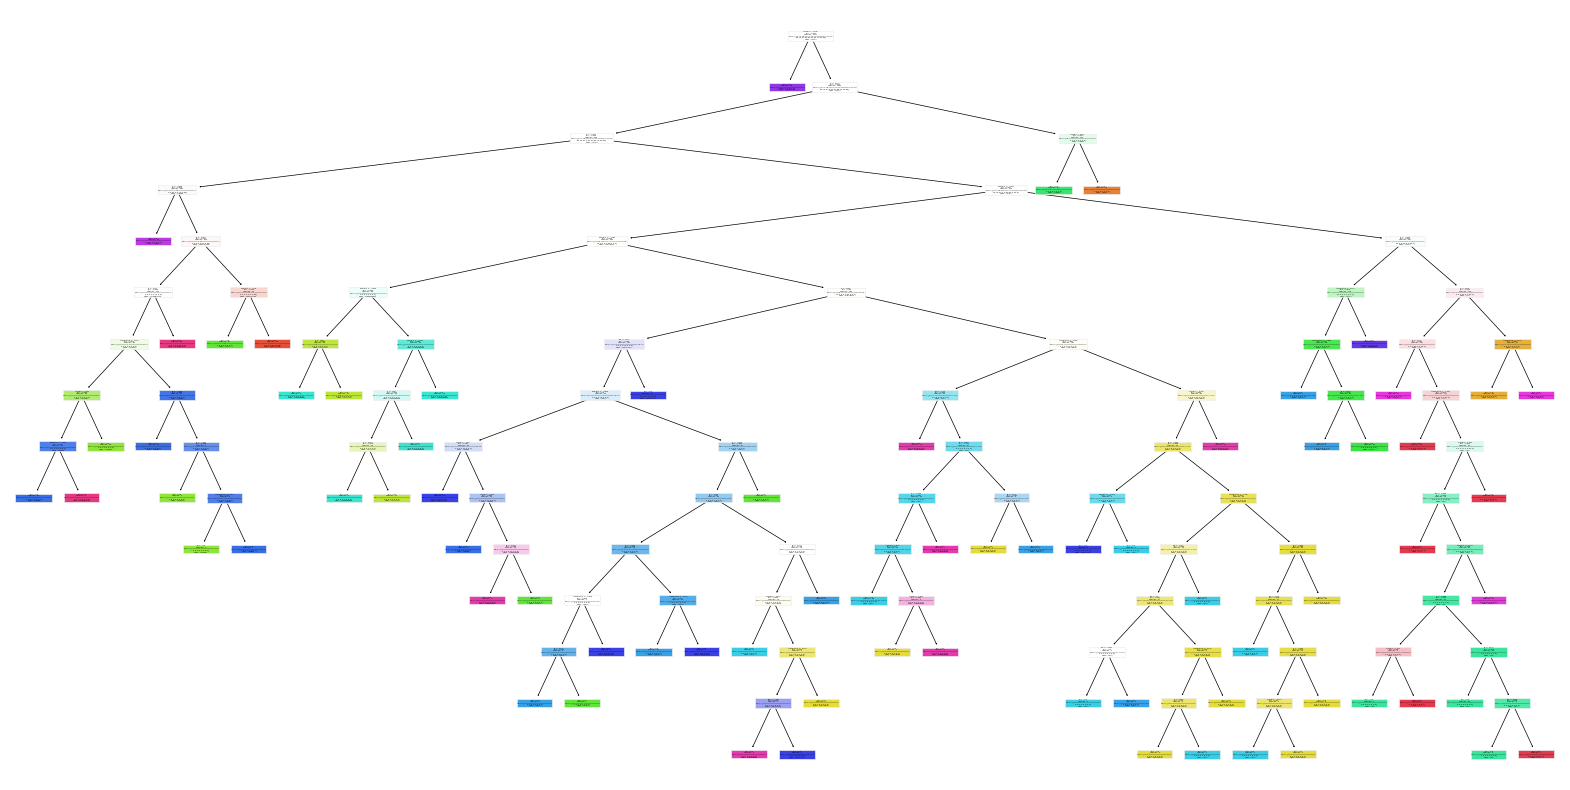

In [750]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming `model` is your trained RandomForestClassifier
# Visualize the first tree
plt.figure(figsize=(20,10))
plot_tree(rf_clf.named_steps['classifier'].estimators_[0], filled=True, feature_names=X_train.columns, class_names=label_encoder.classes_)
plt.show()


### **4.3 Hyperparameter Tuning**

In [751]:
# FOR DEBUGGING PIPELINE
print(rf_clf)

# Using StratifiedKFold for cross-validation
f1_scoring = make_scorer(f1_score, average='macro', zero_division=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_clf, X_train, y_train, cv=skf, scoring=f1_scoring)

print(f"Cross-validation scores: {scores}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['N', 'P', 'K', 'temperature',
                                                   'humidity', 'ph',
                                                   'rainfall'])])),
                ('classifier', RandomForestClassifier(random_state=42))])
Cross-validation scores: [0.99706745 0.98886138 0.99152228 0.99706745 0.9941349 ]


In [752]:
# param_grid = {
#     'classifier__criterion': ['gini', 'entropy'],
#     'classifier__max_depth': [None, 10, 20, 30],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__min_samples_leaf': [1, 2, 4],
#     'classifier__max_features': [None, 'sqrt', 'log2']
# }

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV with the pipeline
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring=f1_scoring, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best cross-validation score: 0.9947934808768817


In [753]:
# Evaluate the model with the best found parameters on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      1.00      1.00        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14
      papaya       1.00    

In [754]:
# Calculate Hamming Loss
print("Hamming Loss:", round(hamming_loss(y_test, y_pred), 4))

Hamming Loss: 0.0045


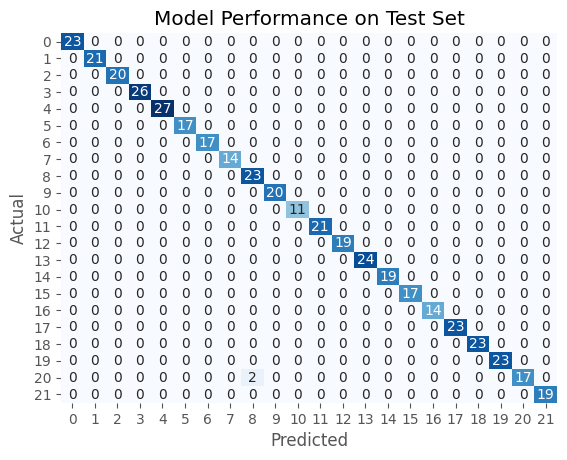

In [755]:
y_pred_dt = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_dt)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Model Performance on Test Set')
plt.show()

In [756]:
interpret_label

label  label_enc
1500        apple          0
1000       banana          1
700     blackgram          2
200      chickpea          3
1800      coconut          4
2100       coffee          5
1900       cotton          6
1200       grapes          7
2000         jute          8
300   kidneybeans          9
800        lentil         10
100         maize         11
1100        mango         12
500     mothbeans         13
600      mungbean         14
1400    muskmelon         15
1600       orange         16
1700       papaya         17
400    pigeonpeas         18
900   pomegranate         19
0            rice         20
1300   watermelon         21

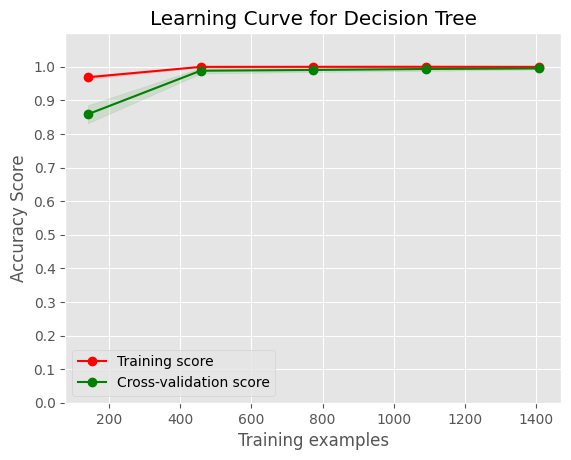

In [757]:
plt.style.use('ggplot')

# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plt.figure(dpi=200)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve for Decision Tree')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

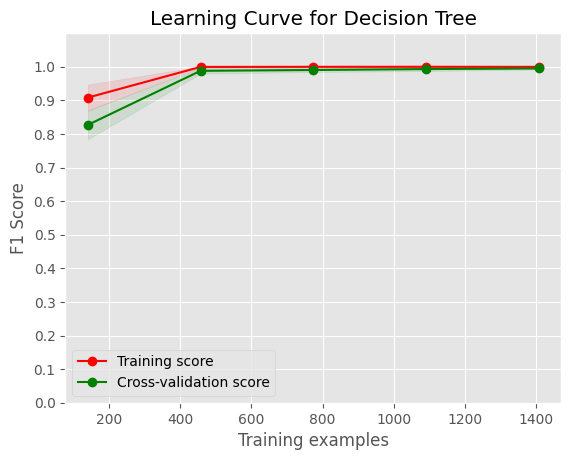

In [758]:
# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring=f1_scoring, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plt.figure(dpi=200)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('F1 Score')
plt.title('Learning Curve for Decision Tree')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

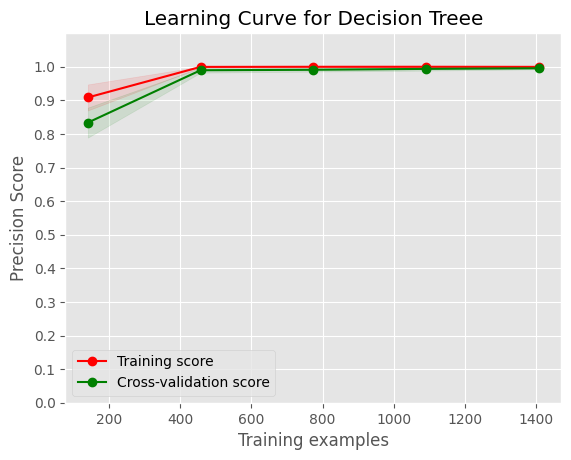

In [759]:
# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, 
                                                        scoring=make_scorer(precision_score, average='macro', zero_division=0), 
                                                        n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plt.figure(dpi=200)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('Precision Score')
plt.title('Learning Curve for Decision Treee')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

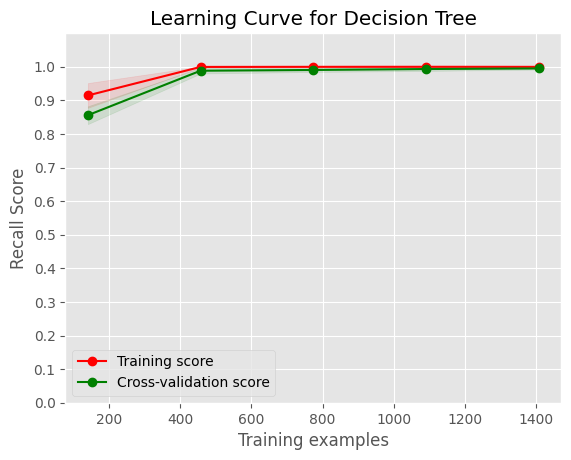

In [760]:
# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, 
                                                        scoring=make_scorer(recall_score, average='macro'), 
                                                        n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plt.figure(dpi=200)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('Recall Score')
plt.title('Learning Curve for Decision Tree')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()


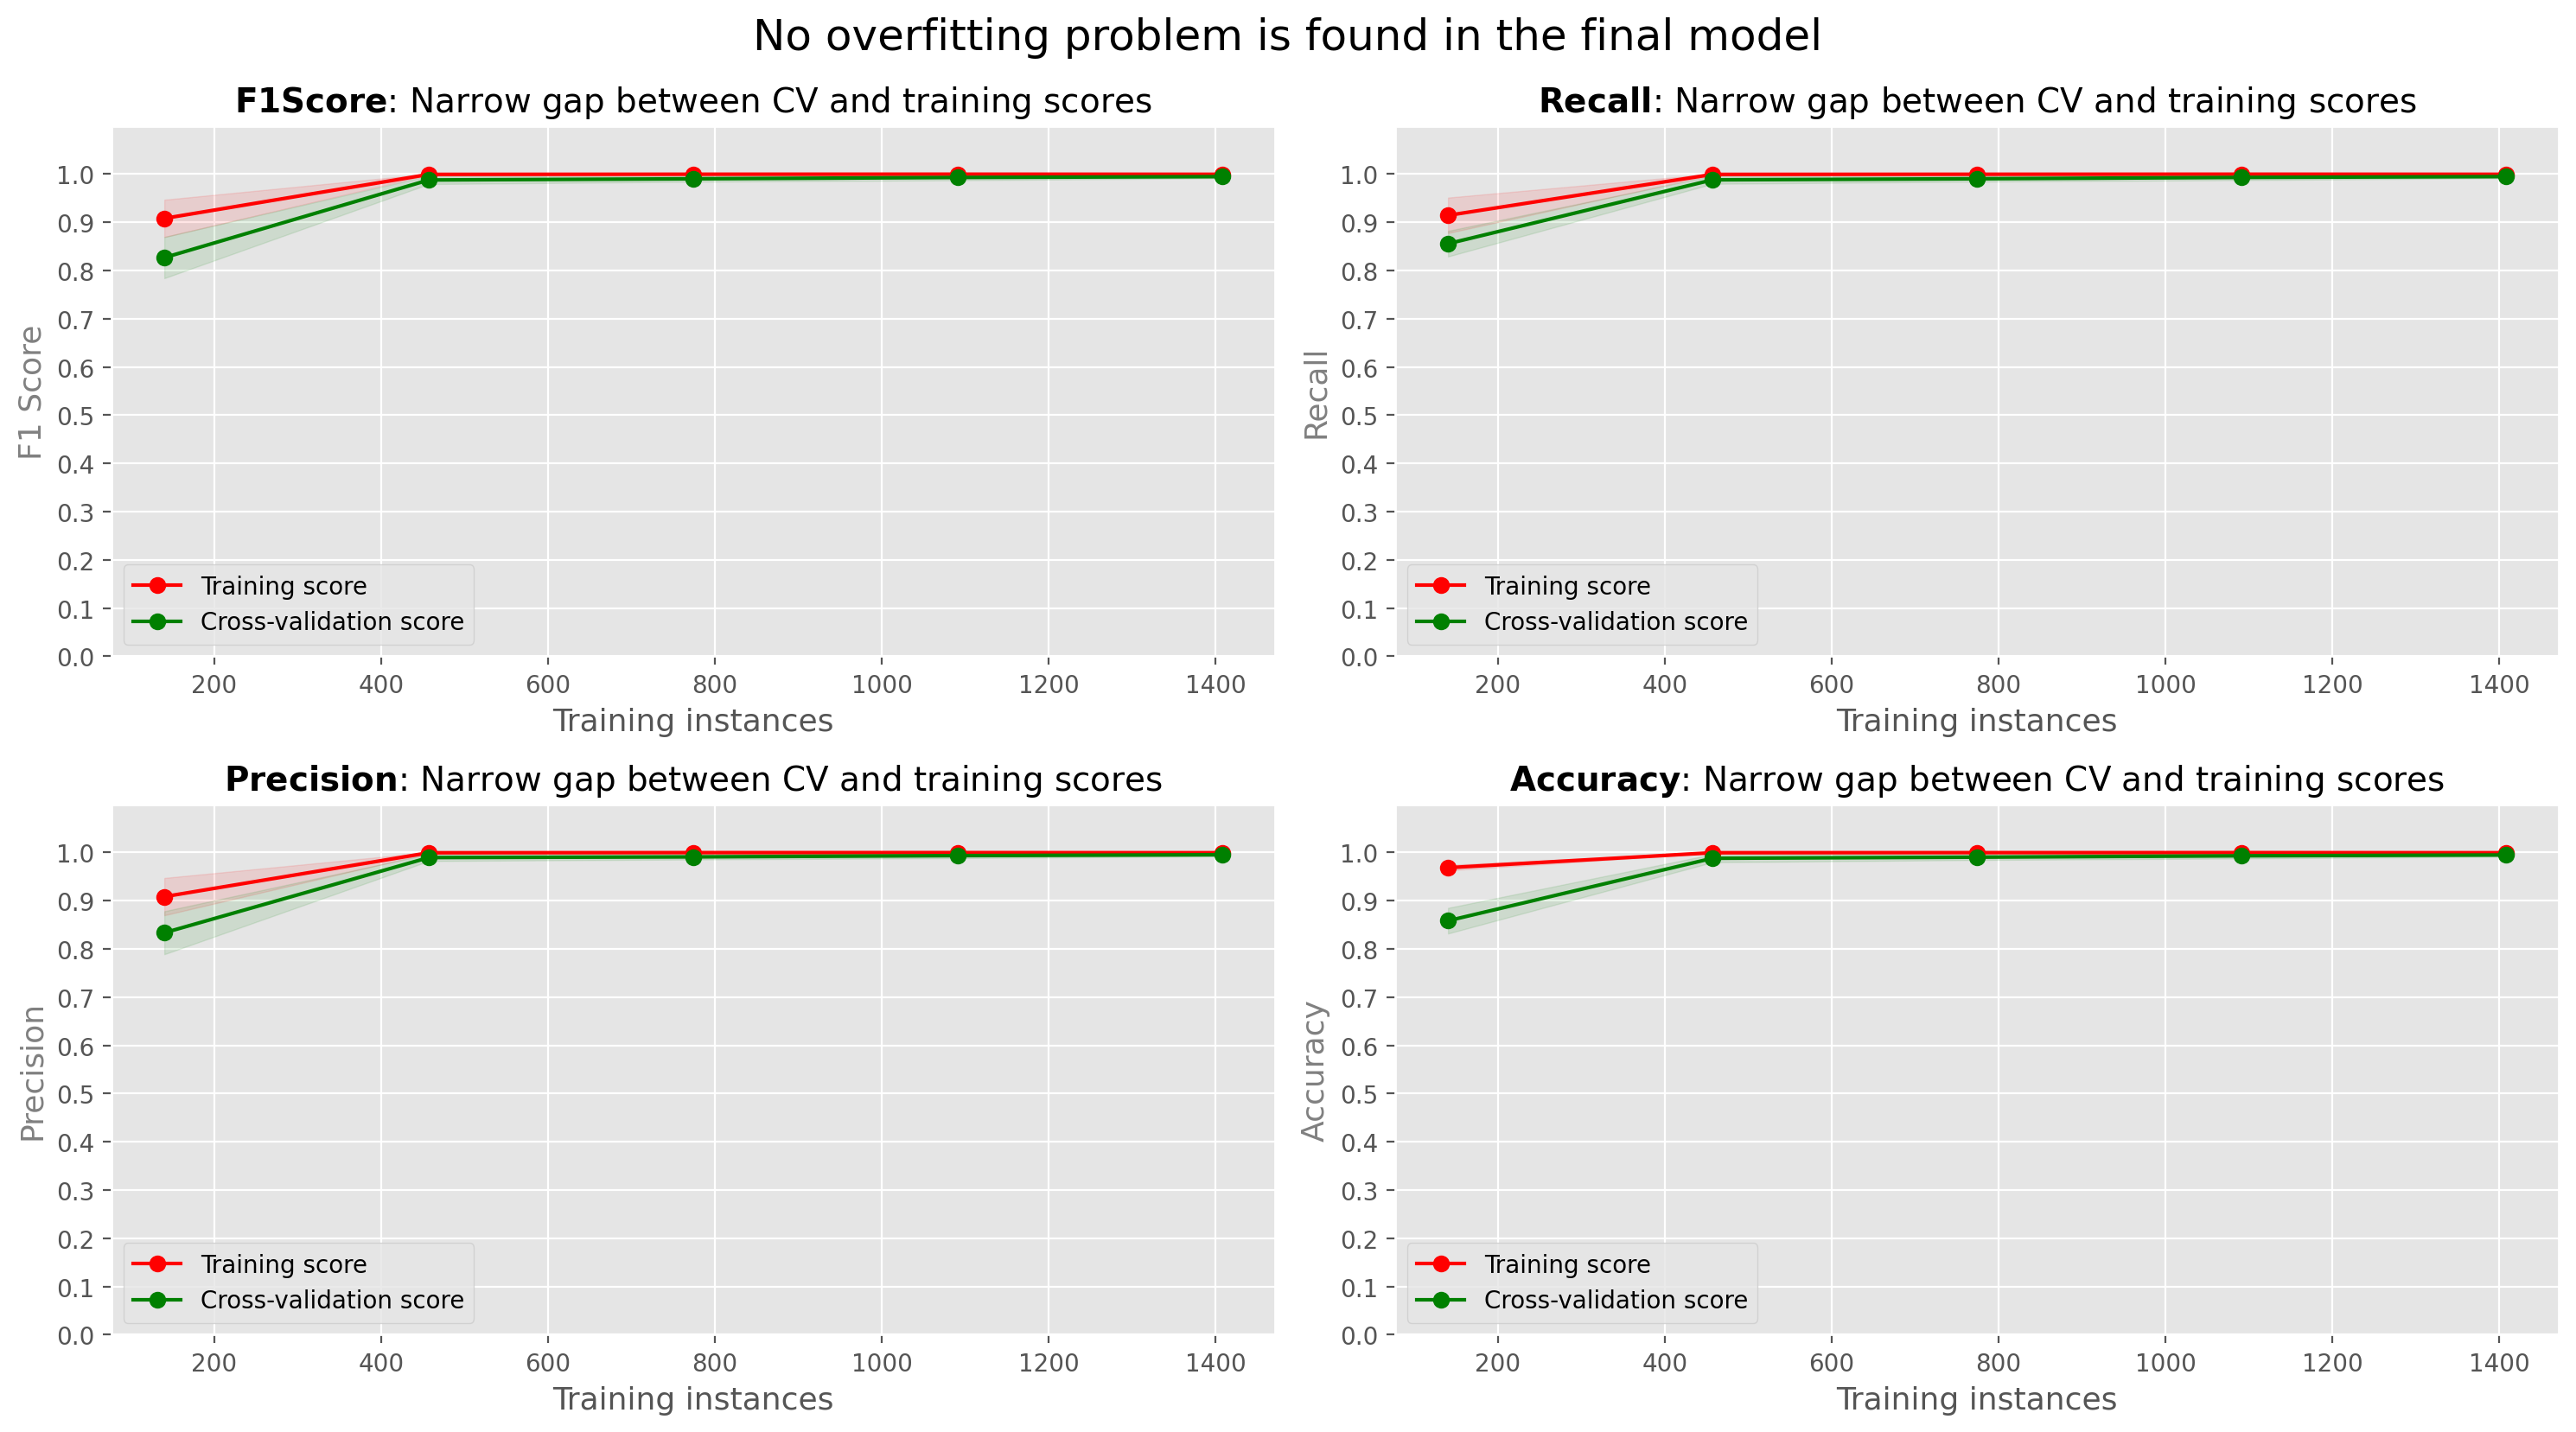

In [817]:
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Define custom scorers
scoring = {
    'F1 Score': make_scorer(f1_score, average='macro', zero_division=0),
    'Recall': make_scorer(recall_score, average='macro', zero_division=0),
    'Precision': make_scorer(precision_score, average='macro', zero_division=0),
    'Accuracy': make_scorer(accuracy_score)
}

# Init the figure and axis array
fig, axes = plt.subplots(2, 2, figsize=(15, 8), dpi=200)
axes = axes.ravel()  

# Loop through each metric
for i, (metric_name, scorer) in enumerate(scoring.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X_train, y_train, cv=5, scoring=scorer, n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    axes[i].set_xlabel('Training instances', size=13)
    axes[i].set_ylabel(metric_name, size=13, color='grey')
    axes[i].set_title(rf'$\bf{{{metric_name}}}$: Narrow gap between CV and training scores', size=14)
    axes[i].legend(loc="best")
    axes[i].set_ylim(0, 1.1)
    axes[i].set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.suptitle('No overfitting problem is found in the final model', 
             y=1.03, size=18)
plt.show()


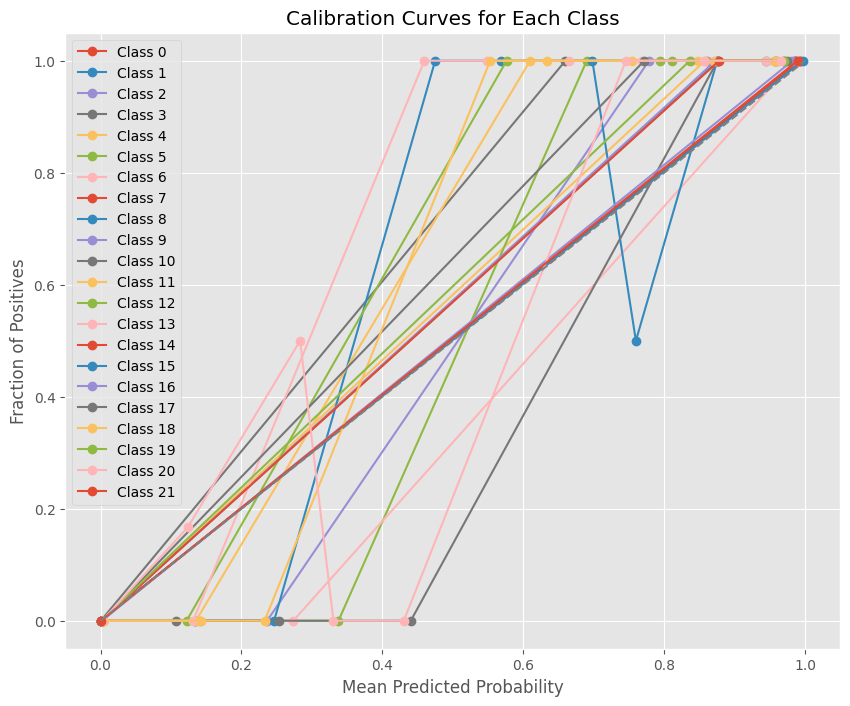

In [761]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

# Assuming 'best_model' is your trained model and 'X_test' is your test data
y_pred_proba = best_model.predict_proba(X_test)

# Binarize the y_test for multiclass
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)

# Plot calibration curve for each class
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(best_model.classes_):
    prob_true, prob_pred = calibration_curve(y_test_binarized[:, i], y_pred_proba[:, i], n_bins=10)
    
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_label}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves for Each Class')
plt.legend(loc='best')
plt.show()

brier score here

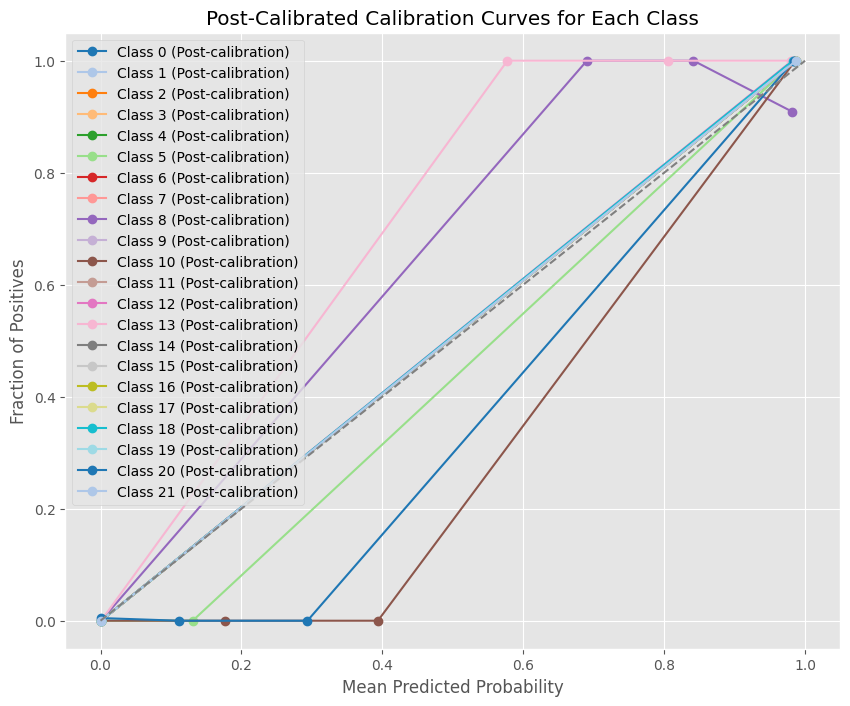

In [762]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import brier_score_loss

# Calibrate the model using CalibratedClassifierCV
calibrated_model = CalibratedClassifierCV(estimator=best_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train, y_train)

# Predict post-calibrated probabilities on the test set
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)

# Binarize the y_test for multiclass calibration curve
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)

# Define a colormap
cmap = plt.get_cmap('tab20')

# Plot post-calibration calibration curve for each class
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(best_model.classes_):
    color = cmap(i % 20)
    prob_true, prob_pred = calibration_curve(y_test_binarized[:, i], y_pred_proba_calibrated[:, i], n_bins=10)
    
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_label} (Post-calibration)', color=color)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Post-Calibrated Calibration Curves for Each Class')
plt.legend(loc='upper left')
plt.show()

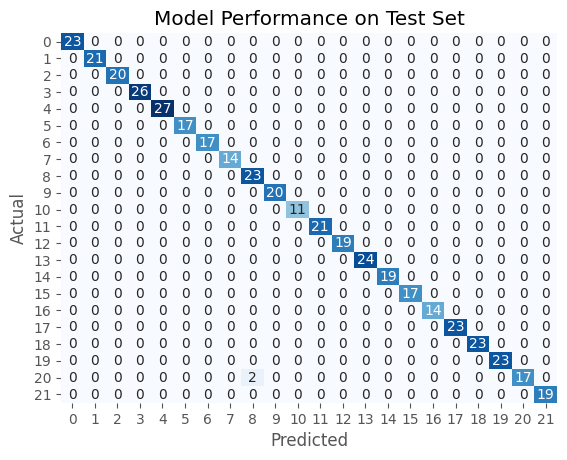

In [763]:
y_pred_dt = calibrated_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_dt)
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Model Performance on Test Set')
plt.show()

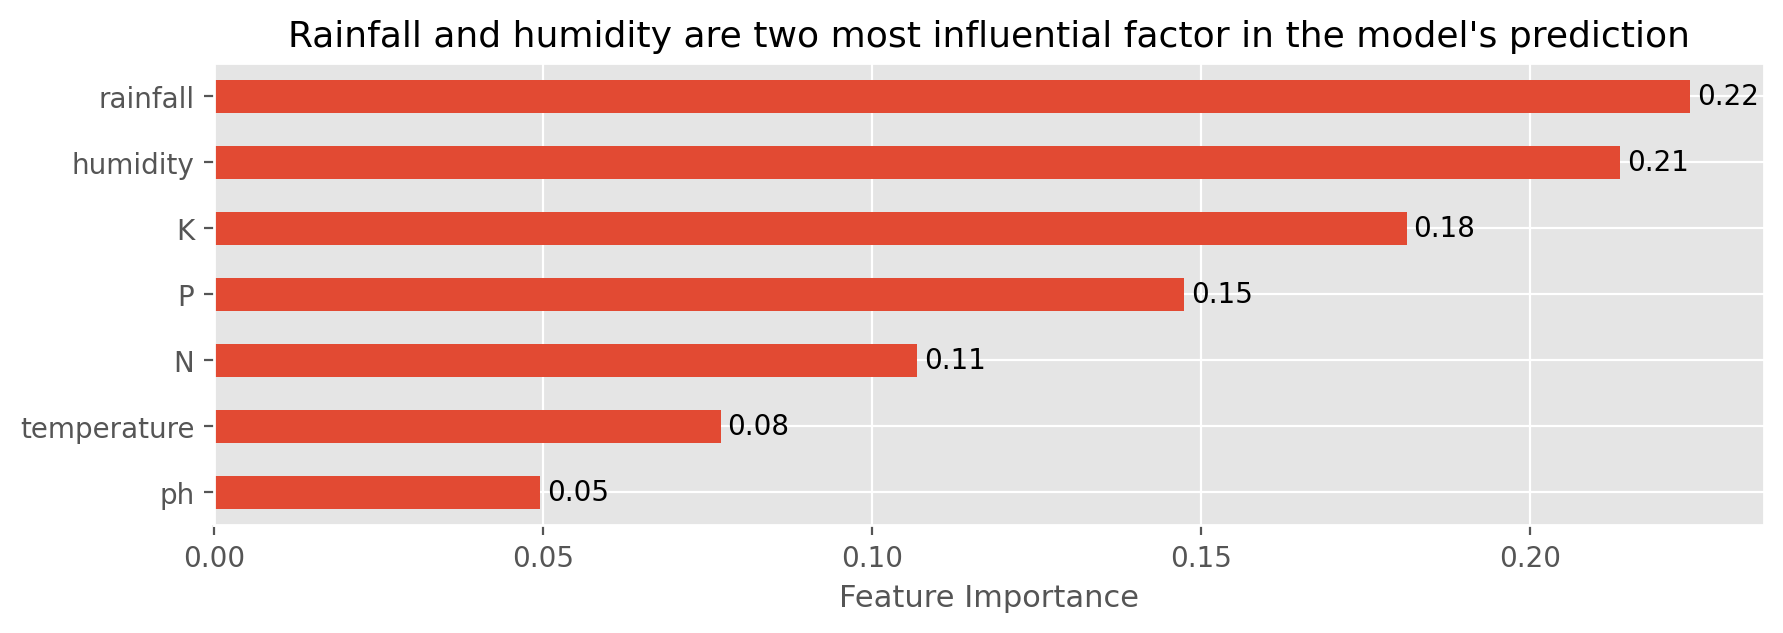

In [833]:
# Assuming 'label_enc' is the column to exclude
feature_names = X_train.columns

# Create a Series of feature importances with corresponding feature names
importances = pd.Series(best_model.named_steps['classifier'].feature_importances_, index=feature_names)

# Sort the importances
importances_sorted = importances.sort_values()

# Plot the feature importances as a horizontal bar plot
plt.figure(figsize=(10, 3), dpi=200)
ax = importances_sorted.plot(kind='barh')

# Add labels to each bar
for i in ax.patches:
    ax.text(i.get_width() + 0.001, i.get_y() + i.get_height()/2, f'{i.get_width():.2f}', 
            va='center', ha='left')

plt.xlabel('Feature Importance', size=11)
plt.title('Rainfall and humidity are two most influential factor in the model\'s prediction', size=13)
plt.show()

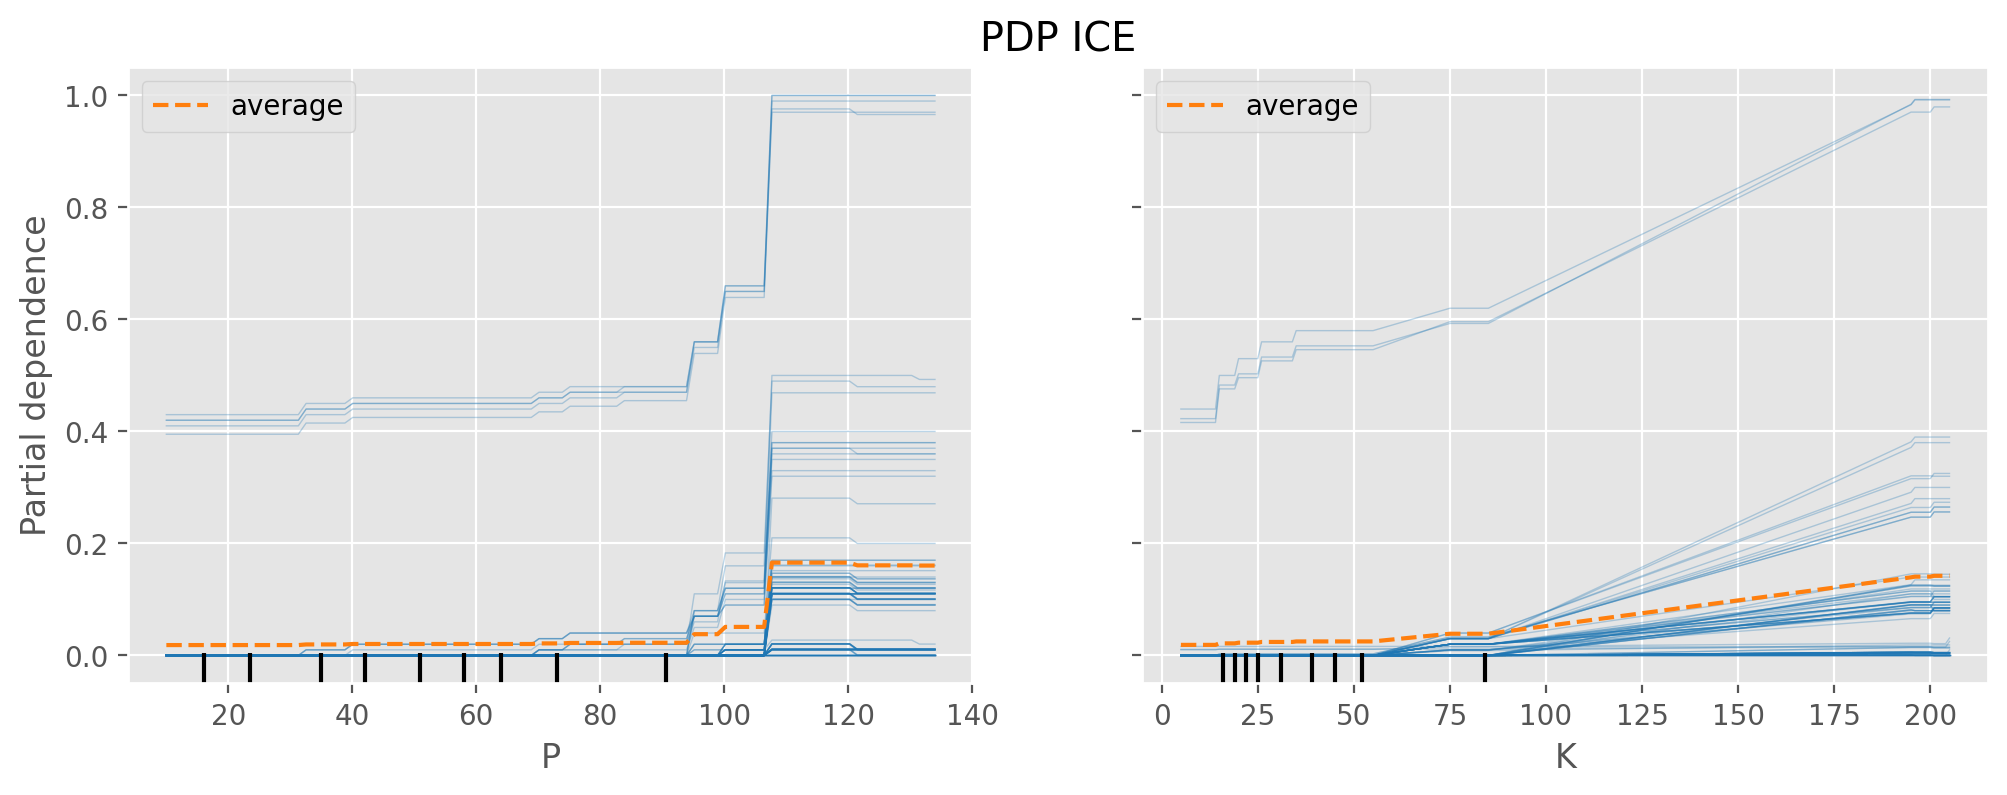

In [811]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

# Create combined PDP and ICE plot with adjusted subsample
PartialDependenceDisplay.from_estimator(best_model, X_train, ['P', 'K'], kind='both', target=0, subsample=100, ax=ax)

# Set the title
ax.set_title('PDP ICE')

# Show the plot
plt.show()

In [820]:
import shap
shap.initjs()

In [803]:
explainer = shap.KernelExplainer(best_model.named_steps['classifier'].predict_proba, X_train)
shap_values = explainer.shap_values(X_test.iloc[0, :])
shap.force_plot(explainer.expected_value[0], shap_values[:, 0], X_test.iloc[0, :])

Using 1760 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.KernelExplainer(best_model.named_steps['classifier'].predict_proba, X_train)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Plot a summary plot for all instances
shap.summary_plot(shap_values, X_test)

# Plot a force plot for the first instance
shap.plots.waterfall(shap_values[0][0])

In [818]:
# apply preprocessing to get the transformed feature names
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# get feature names
def get_unique_feature_names(preprocessor):
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'named_steps'):
            steps = transformer.named_steps
            if 'cat' in steps and hasattr(steps['cat'], 'get_feature_names_out'):
                feature_names.extend(steps['cat'].get_feature_names_out(columns))
            else:
                feature_names.extend(columns)
        elif hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(columns))
        else:
            feature_names.extend(columns)
    return feature_names

unique_feature_names = get_unique_feature_names(preprocessor)

In [ ]:
# create a SHAP TreeExplainer
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])

# calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed)

# visualize global feature importance
shap.summary_plot(shap_values, X_test_transformed, 
                  feature_names=unique_feature_names, 
                  title="SHAP Summary Plot", 
                  plot_size=(12, 8))